# Section 0: Mandatory

In [1]:
%load_ext tensorboard
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import gc
import json
import os
import bz2
import cv2
import dlib
import shutil
import datetime
import tensorflow.keras.layers as lyr
import tensorflow.keras.regularizers as regr
from google.colab.patches import cv2_imshow
from zipfile import ZipFile

In [ ]:
# Only if runs with TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)

ValueError: ignored

# Section 1: Generating TFRecord

In [ ]:
__stage2_dir = 'stage2-dir'
__versionName = 'celeba-selected-paired-v0'
!rm -rf $__stage2_dir
try:
  os.mkdir(__stage2_dir)
except:
  pass

__zipFile = f'gs://count-dracula/selected-dataset/{__versionName}.zip'
__jsnFile = f'gs://count-dracula/selected-dataset/{__versionName}.json'
!gsutil -m cp $__zipFile $__stage2_dir
!gsutil -m cp $__jsnFile $__stage2_dir
shutil.unpack_archive(
  f'{__stage2_dir}/{__versionName}.zip',
  f'{__stage2_dir}/{__versionName}',
  'zip'
)

Copying gs://count-dracula/selected-dataset/celeba-selected-paired-v0.zip...
- [1/1 files][ 78.1 MiB/ 78.1 MiB] 100% Done  12.0 MiB/s ETA 00:00:00           
Operation completed over 1 objects/78.1 MiB.                                     
Copying gs://count-dracula/selected-dataset/celeba-selected-paired-v0.json...
| [1/1 files][  7.6 MiB/  7.6 MiB] 100% Done                                    
Operation completed over 1 objects/7.6 MiB.                                      


In [ ]:
squareSize = 218.0
sizeHMultiplier = squareSize / 218.0
sizeWMultiplier = squareSize / 178.0
__features = tf.keras.utils.image_dataset_from_directory(
  directory = f'{__stage2_dir}',
  image_size = (218, 218), #218, 178 original
  label_mode = None,
  color_mode = 'rgb',
  shuffle = False,
  batch_size = 2
)

__paths = [i.split('/')[-1].split('.')[0] for i in __features.file_paths]

with open(f'{__stage2_dir}/{__versionName}.json', 'r') as f:
  __jsonLabels = json.load(f)

__targets = []

for i in __paths:
  __targets.append(
    __jsonLabels[i]['p']['x'] + __jsonLabels[i]['p']['y'] + [__jsonLabels[i]['d']]
  )

__targets = tf.data.Dataset.from_tensor_slices(
  tf.constant(__targets, dtype=tf.float32)
).batch(2)

Found 11736 files belonging to 1 classes.


In [ ]:
def targetMapper(x):
  resizedX = x[:,:68] * sizeWMultiplier
  resizedY = x[:,68:-1] * sizeHMultiplier
  D = tf.expand_dims(x[:,-1], axis=1)
  return tf.concat([resizedX, resizedY, D], axis=1)

__targets = __targets.map(lambda x: targetMapper(x))

In [ ]:
#initVal = tf.fill((2, 137), -1)
#initVal = tf.Variable(initVal, dtype=tf.int32)

def getMax(prev, curr):
    return tf.math.maximum(prev, curr)

def getMin(prev, curr):
    return tf.math.minimum(prev, curr)

maxEdges = (
  __targets
  .map(lambda x: x[:,:-1])
  .reduce(initial_state=0.0, reduce_func=getMax)
)
minEdges = (
  __targets
  .map(lambda x: x[:,:-1])
  .reduce(initial_state=squareSize, reduce_func=getMin)
)

In [ ]:
__features0 = __features.map(lambda x: tf.cast(x[0], tf.float32) / 255.0)
__features1 = __features.map(lambda x: tf.cast(x[1], tf.float32) / 255.0)
__targets0 = __targets.map(
  lambda x: ((x[0,:-1] - minEdges[0]) / (maxEdges[0] - minEdges[0]))
)
__targets1 = __targets.map(
  lambda x: ((x[1,:-1] - minEdges[1]) / (maxEdges[1] - minEdges[1]))
)
__targetsD = __targets.map(lambda x: tf.cast(x[0, -1], tf.float32))
allX = tf.data.Dataset.zip({
  'feature0': __features0,
  'feature1':__features1
})
allY = tf.data.Dataset.zip({
  'target0': __targets0,
  'target1':__targets1,
  'targetD': __targetsD
})
allDs = tf.data.Dataset.zip({'features': allX, 'targets': allY})

In [ ]:
dEqu1 = 0
dEqu0 = 0
for i in __targetsD.filter(lambda x: x == 0):
  dEqu1 += 1
for i in __targetsD.filter(lambda x: x == 1):
  dEqu0 += 1

In [ ]:
trainDsEqu0 = allDs.take(int(3 * dEqu0 / 4))
trainDsEqu1 = allDs.skip(dEqu0).take(int(3 * dEqu1 / 4))
shuffleBuffer = int(3 * dEqu0 / 4) + int(3 * dEqu1 / 4)

trainDs = (trainDsEqu0
           .concatenate(trainDsEqu1)
           .shuffle(shuffleBuffer, reshuffle_each_iteration=False)
           .batch(32))

valDsEqu0 = allDs.skip(int(3 * dEqu0 / 4)).take(int(dEqu0/4))
valDsEqu1 = allDs.skip(dEqu0).skip(int(3 * dEqu1 / 4)).take(int(dEqu1/4))
shuffleBuffer = int(dEqu0 / 4) + int(dEqu1 / 4)
valDs = (valDsEqu0
         .concatenate(valDsEqu1)
         .shuffle(shuffleBuffer, reshuffle_each_iteration=False)
         .batch(32))

In [ ]:
print('TrainDs batch total: ', trainDs.cardinality().numpy())
print('ValDs batch total: ', valDs.cardinality().numpy())


TrainDs batch total:  138
ValDs batch total:  46


In [ ]:
def makeTFRecord(dataset, filename):
  with tf.io.TFRecordWriter(filename) as f:
    for i in dataset:
      feature0 = tf.io.serialize_tensor(i['features']['feature0'])
      feature1 = tf.io.serialize_tensor(i['features']['feature1'])
      target0 = tf.io.serialize_tensor(i['targets']['target0'])
      target1 = tf.io.serialize_tensor(i['targets']['target1'])
      targetD = tf.io.serialize_tensor(i['targets']['targetD'])

      dataFeature = {
        'feature0': tf.train.Feature(
          bytes_list = tf.train.BytesList(value=[feature0.numpy()])
        ),
        'feature1': tf.train.Feature(
          bytes_list = tf.train.BytesList(value=[feature1.numpy()])
        ),
        'target0': tf.train.Feature(
          bytes_list = tf.train.BytesList(value=[target0.numpy()])
        ),
        'target1': tf.train.Feature(
          bytes_list = tf.train.BytesList(value=[target1.numpy()])
        ),
        'targetD': tf.train.Feature(
          bytes_list = tf.train.BytesList(value=[targetD.numpy()])
        )
      }
      collective = tf.train.Features(feature=dataFeature)
      record_bytes = tf.train.Example(features=collective).SerializeToString()

      f.write(record_bytes)

In [ ]:
makeTFRecord(valDs, 'valDs.tfrecord')
makeTFRecord(trainDs, 'trainDs.tfrecord')

In [ ]:
storageName = 'handsome-dracula'
path = '/machine-learning/dataset-tfrecord'
!gsutil cp -r "trainDs.tfrecord" "$(echo gs://$storageName$path)"
!gsutil cp -r "valDs.tfrecord" "$(echo gs://$storageName$path)"

Copying file://trainDs.tfrecord [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/4.7 GiB.                                      
Copying file://valDs.tfrecord [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster 

# Section 2: Load TFRecord

In [2]:
!pip3 install --no-cache-dir -U crcmod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp310-cp310-linux_x86_64.whl size=31403 sha256=bf2b50dc7b380a8961739976521dedc49d490d77589ef0420da5aec311701733
  Stored in directory: /tmp/pip-ephem-wheel-cache-nyf1gk6b/wheels/85/4c/07/72215c529bd59d67e3dac29711d7aba1b692f543c808ba9e86
Successfully built crcmod


In [3]:
storageName = 'handsome-dracula'
path = '/machine-learning/dataset-tfrecord'

!gsutil cp -r "$(echo gs://$storageName$path/trainDs.tfrecord)" "trainDs.tfrecord"
!gsutil cp -r "$(echo gs://$storageName$path/valDs.tfrecord)" "valDs.tfrecord"

Copying gs://handsome-dracula/machine-learning/dataset-tfrecord/trainDs.tfrecord...
| [1 files][  4.7 GiB/  4.7 GiB]   63.7 MiB/s                                   
Operation completed over 1 objects/4.7 GiB.                                      
Copying gs://handsome-dracula/machine-learning/dataset-tfrecord/valDs.tfrecord...
/ [1 files][  1.6 GiB/  1.6 GiB]   78.0 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      


In [4]:
def readTFRecord(filename):
  features = {
  'feature0': tf.io.FixedLenFeature([], tf.string),
  'feature1': tf.io.FixedLenFeature([], tf.string),
  'target0': tf.io.FixedLenFeature([], tf.string),
  'target1': tf.io.FixedLenFeature([], tf.string),
  'targetD': tf.io.FixedLenFeature([], tf.string),
  }

  def decoder(n):
    singleParser = tf.io.parse_single_example(n, features)
    feature0 = tf.io.parse_tensor(singleParser['feature0'], tf.float32)
    feature1 = tf.io.parse_tensor(singleParser['feature1'], tf.float32)
    target0 = tf.io.parse_tensor(singleParser['target0'], tf.float32)
    target1 = tf.io.parse_tensor(singleParser['target1'], tf.float32)
    targetD = tf.io.parse_tensor(singleParser['targetD'], tf.float32)
    dataStructure = {
      'features': {
        'feature0': feature0,
        'feature1': feature1
      },
      'targets': {
        'target0': target0,
        'target1': target1,
        'targetD': targetD
      }
    }
    #return ((feature0, feature1), (target0, target1, targetD))
    return (dataStructure)

  return tf.data.TFRecordDataset(filename).map(decoder)

In [5]:
trainDs = readTFRecord('trainDs.tfrecord').prefetch(tf.data.AUTOTUNE)
valDs = readTFRecord('valDs.tfrecord').prefetch(tf.data.AUTOTUNE)

#if using TPU
# trainDs = readTFRecord('gs://handsome-dracula/machine-learning/dataset-tfrecord/trainDs.tfrecord')
# valDs = readTFRecord('gs://handsome-dracula/machine-learning/dataset-tfrecord/valDs.tfrecord')

NameError: ignored

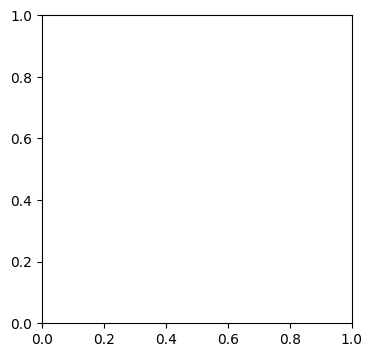

In [ ]:
def mapper(x, j):
  return (x *
          (maxEdges[j] - minEdges[j]) +
          minEdges[j])

for i in trainDs.unbatch().take(10):
  f, ax = plt.subplots(1, figsize=(4,4))
  i0 = mapper(i['targets']['target0'], 0)
  i1 = mapper(i['targets']['target1'], 1)
  concat = tf.concat([i['features']['feature0'], i['features']['feature1']], axis=1)
  ax.imshow(concat)
  ax.scatter(i0[:68], i0[68:], s=0.3, c='yellow')
  ax.scatter(i1[:68] + squareSize, i1[68:], s=0.3, c='yellow')
  ax.get_yaxis().set_visible(False)
  ax.get_xaxis().set_visible(False)
  if (i['targets']['targetD'] == 1):
    msg = 'the same person (1)'
  else:
    msg = 'different person (0)'
  ax.set_title(f"It's fucking {msg}")

## Model Construction

### Costumized Layers, Activations, and Losses

In [6]:
alpha, beta, gamma = 0.5, 0.5, 1
tf.random.set_seed(2356)
@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="Loss2"
)
class Loss2(tf.keras.losses.Loss):
  def __init__(self, delta=1):
    super().__init__()
    self.delta = delta

  def call (self, y_true, y_pred):
    a2 = y_true * tf.math.square(y_pred) #? x 1
    b2 = (1 - y_true) * tf.math.square(
        tf.math.maximum(self.delta - y_pred, 0)
    )
    c2 = a2 + b2
    return c2 * gamma

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="Loss1"
)
class Loss1(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()

  def call (self, y_true, y_pred):
    a1 = y_true # ? x 136
    b1 = y_pred # ? x 136
    c1 = tf.math.sqrt(
      tf.math.reduce_sum(
        tf.math.square(a1 - b1),
        axis = -1,
        keepdims = True),
    ) / tf.cast(tf.shape(y_pred)[0], dtype=tf.float32)
    return c1 * beta

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="Loss0"
)
class Loss0(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()

  def call (self, y_true, y_pred):
    a0 = y_true # ? x 136
    b0 = y_pred # ? x 136
    c0 = tf.math.sqrt(
      tf.math.reduce_sum(
        tf.math.square(a0 - b0),
        axis = -1,
        keepdims = True),
    ) / tf.cast(tf.shape(y_pred)[0], dtype=tf.float32)
    return c0 * alpha

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="angularDist"
)
def angularDist(vects):
  r0, r1 = vects
  dotProduct = tf.math.reduce_sum(r0 * r1, axis=-1) + tf.keras.backend.epsilon()
  lengthR0 = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(r0), axis=-1)) + tf.keras.backend.epsilon()
  lengthR1 = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(r1), axis=-1)) + tf.keras.backend.epsilon()
  return tf.math.acos(dotProduct/(lengthR0 * lengthR1))

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="lambdaNormalizer"
)
def lambdaNormalizer(max=1, min=-1):
  def do(x):
    return x / 218
  return do

@tf.keras.saving.register_keras_serializable(
  package="resqhubModel",
  name="NormedDense"
)
class NormedDense(tf.keras.layers.Layer):
  def __init__(self, units=32, **kwargs):
    super(NormedDense, self).__init__(**kwargs)
    self.units = units

  def build(self, input_shape):
    __init_w = tf.random_uniform_initializer()
    __init_b = tf.random_uniform_initializer()

    self.w = tf.Variable(
      name = 'weights',
      initial_value = __init_w(
        shape = (input_shape[-1], self.units),
        dtype = 'float32'
      ),
      trainable = True
    )
    self.b = tf.Variable(
      name = 'bias',
      initial_value = __init_b(
        shape = (self.units,),
        dtype='float32'
      ),
      trainable = True
    )

  def get_config(self):
    config = super().get_config()
    config.update({
        'units': self.units
    })
    return config

  def call(self, inputs):
    matrix = tf.linalg.matmul(inputs, self.w) + self.b
    return matrix

### Model Construction Core

In [7]:
def resnetClip():
  z = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
  )
  for i in z.layers:
    i.trainable = True
  tipStart = z.layers[1].input
  tipEnd = z.get_layer('mixed5').output #mixed6 (model 4) #mixed5 (model 5)
  resnetClip = tf.keras.Model(inputs=[tipStart], outputs=[tipEnd])
  return resnetClip

def head(__shape):
  __inp = lyr.Input(__shape)
  __cnn = lyr.Conv2D(16, (3,3), activation='elu', name='headConv0')(__inp)
  __cnn = lyr.MaxPooling2D((2,2))(__cnn)
  __flt = lyr.Flatten()(__cnn)
  return tf.keras.Model(inputs=[__inp], outputs=[__flt])

def neck(__shape):
  __inp = lyr.Input(shape=__shape)
  __dense = lyr.Dense(128,
                      activation='gelu',
                      #activity_regularizer=regr.L2(0.01),
                      name='neckDense1')(__inp)
  #__dense = lyr.Dropout(.05)(__dense)
  __dense = lyr.Dense(256, activation='elu', name='neckDense2')(__dense)
  return tf.keras.Model(inputs=[__inp], outputs=[__dense])

def tail(__shape):
  __inp = lyr.Input(shape=__shape)
  __dense = lyr.Dense(256,
                      activation='gelu',
                      #activity_regularizer=regr.L2(0.01),
                      name='tailDense0')(__inp)
  __dense = lyr.Dropout(.02)(__dense)
  __dense = lyr.Dense(316,
                      activation='tanh',
                      #activity_regularizer=regr.L2(0.1),
                      name='tailDense3')(__dense)
  __dense = lyr.Dropout(.01)(__dense)
  return tf.keras.Model(inputs=[__inp], outputs=[__dense])

### Model Mapping

In [8]:
def body():
  inp0 = tf.keras.layers.Input(shape=(218, 218, 3), name='feature0')
  inp1 = tf.keras.layers.Input(shape=(218, 218, 3), name='feature1')

  topHeadMdl = resnetClip()
  aux0 = topHeadMdl(inp0)
  aux1 = topHeadMdl(inp1)

  headMdl = head(aux0.shape[1:])
  aux0 = headMdl(aux0)
  aux1 = headMdl(aux1)

  neckMdl = neck(aux0.shape)
  auxNeck0 = neckMdl(aux0)
  auxNeck1 = neckMdl(aux1)

  landmarks0 = NormedDense(136, name='target0')(auxNeck0)
  landmarks1 = NormedDense(136, name='target1')(auxNeck1)

  tailMdl = tail(landmarks0.shape)
  aux0 = tailMdl(landmarks0)
  aux1 = tailMdl(landmarks1)

  lmdb = tf.keras.layers.Lambda(angularDist, name='targetD')([aux0, aux1])
  return tf.keras.models.Model(inputs=[inp0, inp1], outputs=[landmarks0, landmarks1, lmdb])


## Model Training Utilities

In [9]:
def saveCheckpoint(model, hist, serial, checkNum):
  !rm -rf $serial
  try:
    os.mkdir(serial)
  except:
    pass
  mdlName = f'{serial}-checkpoint{checkNum}'
  model.save(f'{serial}/{mdlName}.h5')
  history = hist.history
  with open(f'{serial}/{mdlName}.json', 'w') as f:
    json.dump(history, f)
  !gsutil cp -r $serial "$(echo gs://handsome-dracula/machine-learning/model-checkpoints)"

def loadCheckpoint(serial, checkNum, independentModel=False):
  !rm -rf $serial
  try:
    os.mkdir(serial)
  except:
    pass
  try:
    h5File = f'{serial}/{serial}-checkpoint{checkNum}.h5'
    h5Path = f'gs://handsome-dracula/machine-learning/model-checkpoints/'
    h5FullPath = h5Path + h5File
    !gsutil -m cp $h5FullPath $serial
    if not independentModel:
      mdl = body()
      mdl.load_weights(h5File)
    else:
      mdl = tf.keras.models.load_model(
        f'{serial}/{serial}-checkpoint{checkNum}.h5',
        compile=False
      )
  except:
    print('Unexpected error. Check serial name and checknum.')
  return mdl

def initiateModel():
  return body()

def pairwiseAcc(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  threshold = 0.5  # Adjust the threshold based on your task
  y_pred_binary = tf.cast(tf.math.less(y_pred, threshold), dtype=tf.float32)
  total = tf.shape(y_true)[0]
  validity = tf.shape(tf.where(y_true == y_pred_binary))[0] / total
  return validity

class ContrastiveAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name='contrastive_accuracy', **kwargs):
    self(ContrastiveAccuracy, self).__init__(name=name, **kwargs)
    self.validity = self.add_weight(name='vld', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    threshold = 0.5
    yTrue = tf.cast(y_true, dtype=tf.float32)
    yPred = tf.cast(tf.math.less(y_pred, threshold), dtype=tf.float32)
    total = tf.shape(y_true)[0]
    self.validity = tf.shape(tf.where(yTrue == yPred))[0] / total

  def result(self):
    return self.validity

def trainModel(model, lr=3e-6):
  model.compile(
    loss = [Loss0(), Loss1(), Loss2()],
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr),
    metrics={'targetD': [pairwiseAcc], 'target0': [], 'target1': []}
  )

  hist = model.fit(
      trainDs.map(lambda x: (x['features'], x['targets'])),
      epochs = 30,
      validation_data = valDs.map(lambda x: (x['features'], x['targets'])),
      shuffle = False
  )
  return hist

# Serial: rai-remodel6.1

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 62s 344ms/step - loss: 0.8441 - target0_loss: 0.1131 - target1_loss: 0.1073 - targetD_loss: 0.6131 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.5554 - val_target0_loss: 0.1148 - val_target1_loss: 0.1094 - val_targetD_loss: 0.3180 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/20
138/138 [==============================] - 46s 334ms/step - loss: 0.5118 - target0_loss: 0.1147 - target1_loss: 0.1099 - targetD_loss: 0.2724 - targetD_pairwiseAcc: 0.5009 - val_loss: 0.4940 - val_target0_loss: 0.1140 - val_target1_loss: 0.1096 - val_targetD_loss: 0.2550 - val_targetD_pairwiseAcc: 0.5041
Epoch 3/20
138/138 [==============================] - 46s 337ms/step - loss: 0.4837 - target0_loss: 0.1128 - target1_loss: 0.1087 - targetD_loss: 0.2473 - targetD_pairwiseAcc: 0.5423 - val_loss: 0.4834 - val_target0_loss: 0.1114 - val_target1_loss: 0.1076 - val_targetD_loss: 0.2502 - val_targetD_pairwiseAcc: 0.5362
Epoch 4/20
138/138 [=============================

# Serial: rai-remodel6

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 64s 352ms/step - loss: 0.7841 - target0_loss: 0.1081 - target1_loss: 0.1098 - targetD_loss: 0.5572 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.5397 - val_target0_loss: 0.1099 - val_target1_loss: 0.1109 - val_targetD_loss: 0.3064 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/20
138/138 [==============================] - 47s 343ms/step - loss: 0.5006 - target0_loss: 0.1096 - target1_loss: 0.1111 - targetD_loss: 0.2656 - targetD_pairwiseAcc: 0.5061 - val_loss: 0.4913 - val_target0_loss: 0.1091 - val_target1_loss: 0.1108 - val_targetD_loss: 0.2565 - val_targetD_pairwiseAcc: 0.5192
Epoch 3/20
138/138 [==============================] - 49s 357ms/step - loss: 0.4765 - target0_loss: 0.1080 - target1_loss: 0.1099 - targetD_loss: 0.2441 - targetD_pairwiseAcc: 0.5573 - val_loss: 0.4824 - val_target0_loss: 0.1071 - val_target1_loss: 0.1091 - val_targetD_loss: 0.2525 - val_targetD_pairwiseAcc: 0.5303
Epoch 4/20
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-remodel6', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-remodel6/rai-remodel6-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-remodel6/rai-remodel6-checkpoint1.json [Content-Type=application/json]...
/
Operation completed over 2 objects/41.3 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 62s 342ms/step - loss: 0.2936 - target0_loss: 0.0943 - target1_loss: 0.0972 - targetD_loss: 0.0935 - targetD_pairwiseAcc: 0.9839 - val_loss: 0.3999 - val_target0_loss: 0.0939 - val_target1_loss: 0.0970 - val_targetD_loss: 0.2005 - val_targetD_pairwiseAcc: 0.7243
Epoch 2/20
138/138 [==============================] - 47s 338ms/step - loss: 0.2861 - target0_loss: 0.0935 - target1_loss: 0.0966 - targetD_loss: 0.0874 - targetD_pairwiseAcc: 0.9894 - val_loss: 0.3957 - val_target0_loss: 0.0932 - val_target1_loss: 0.0964 - val_targetD_loss: 0.1977 - val_targetD_pairwiseAcc: 0.7318
Epoch 3/20
138/138 [==============================] - 46s 333ms/step - loss: 0.2791 - target0_loss: 0.0927 - target1_loss: 0.0960 - targetD_loss: 0.0817 - targetD_pairwiseAcc: 0.9937 - val_loss: 0.3915 - val_target0_loss: 0.0924 - val_target1_loss: 0.0957 - val_targetD_loss: 0.1949 - val_targetD_pairwiseAcc: 0.7365
Epoch 4/20
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-remodel6', '2')

Copying file://rai-remodel6/rai-remodel6-checkpoint2.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-remodel6/rai-remodel6-checkpoint2.json [Content-Type=application/json]...
/
Operation completed over 2 objects/41.3 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 64s 355ms/step - loss: 0.1750 - target0_loss: 0.0651 - target1_loss: 0.0739 - targetD_loss: 0.0264 - targetD_pairwiseAcc: 1.0000 - val_loss: 0.3090 - val_target0_loss: 0.0639 - val_target1_loss: 0.0729 - val_targetD_loss: 0.1628 - val_targetD_pairwiseAcc: 0.7698
Epoch 2/20
138/138 [==============================] - 47s 343ms/step - loss: 0.1691 - target0_loss: 0.0626 - target1_loss: 0.0718 - targetD_loss: 0.0251 - targetD_pairwiseAcc: 1.0000 - val_loss: 0.3034 - val_target0_loss: 0.0613 - val_target1_loss: 0.0707 - val_targetD_loss: 0.1619 - val_targetD_pairwiseAcc: 0.7691
Epoch 3/20
138/138 [==============================] - 47s 337ms/step - loss: 0.1632 - target0_loss: 0.0600 - target1_loss: 0.0696 - targetD_loss: 0.0239 - targetD_pairwiseAcc: 1.0000 - val_loss: 0.2977 - val_target0_loss: 0.0587 - val_target1_loss: 0.0684 - val_targetD_loss: 0.1611 - val_targetD_pairwiseAcc: 0.7691
Epoch 4/20
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-remodel6', '3')

Copying file://rai-remodel6/rai-remodel6-checkpoint3.json [Content-Type=application/json]...
Copying file://rai-remodel6/rai-remodel6-checkpoint3.h5 [Content-Type=application/x-hdf5]...
-
Operation completed over 2 objects/41.3 MiB.                                     


# Serial: rai-model6

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 49s 290ms/step - loss: 1.7633 - target0_loss: 0.1083 - target1_loss: 0.1057 - targetD_loss: 0.7291 - targetD_pairwiseAcc: 0.5000 - val_loss: 1.4569 - val_target0_loss: 0.1072 - val_target1_loss: 0.1036 - val_targetD_loss: 0.5847 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/20
138/138 [==============================] - 39s 283ms/step - loss: 1.3631 - target0_loss: 0.1066 - target1_loss: 0.1035 - targetD_loss: 0.5271 - targetD_pairwiseAcc: 0.5000 - val_loss: 1.2771 - val_target0_loss: 0.1060 - val_target1_loss: 0.1033 - val_targetD_loss: 0.4949 - val_targetD_pairwiseAcc: 0.4994
Epoch 3/20
138/138 [==============================] - 38s 277ms/step - loss: 1.2052 - target0_loss: 0.1055 - target1_loss: 0.1032 - targetD_loss: 0.4536 - targetD_pairwiseAcc: 0.5000 - val_loss: 1.1474 - val_target0_loss: 0.1050 - val_target1_loss: 0.1029 - val_targetD_loss: 0.4435 - val_targetD_pairwiseAcc: 0.4994
Epoch 4/20
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model6', '1')

Copying file://rai-model6/rai-model6-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model6/rai-model6-checkpoint1.json [Content-Type=application/json]...
\
Operation completed over 2 objects/10.9 MiB.                                     


In [ ]:
myModel = loadCheckPoint('rai-model1', '1')
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 48s 281ms/step - loss: 0.5351 - target0_loss: 0.0992 - target1_loss: 0.0971 - targetD_loss: 0.2287 - targetD_pairwiseAcc: 0.5521 - val_loss: 0.5745 - val_target0_loss: 0.0992 - val_target1_loss: 0.0970 - val_targetD_loss: 0.2718 - val_targetD_pairwiseAcc: 0.5225
Epoch 2/20
138/138 [==============================] - 39s 283ms/step - loss: 0.5260 - target0_loss: 0.0990 - target1_loss: 0.0968 - targetD_loss: 0.2247 - targetD_pairwiseAcc: 0.5587 - val_loss: 0.5680 - val_target0_loss: 0.0990 - val_target1_loss: 0.0967 - val_targetD_loss: 0.2700 - val_targetD_pairwiseAcc: 0.5238
Epoch 3/20
138/138 [==============================] - 38s 277ms/step - loss: 0.5180 - target0_loss: 0.0988 - target1_loss: 0.0966 - targetD_loss: 0.2215 - targetD_pairwiseAcc: 0.5639 - val_loss: 0.5623 - val_target0_loss: 0.0988 - val_target1_loss: 0.0965 - val_targetD_loss: 0.2690 - val_targetD_pairwiseAcc: 0.5259
Epoch 4/20
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model6', '1')

Copying file://rai-model6/rai-model6-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model6/rai-model6-checkpoint1.json [Content-Type=application/json]...
\
Operation completed over 2 objects/10.9 MiB.                                     


# Serial: rai-model5

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 77s 447ms/step - loss: 0.9597 - target0_loss: 0.1098 - target1_loss: 0.1078 - targetD_loss: 0.6713 - val_loss: 0.6608 - val_target0_loss: 0.1105 - val_target1_loss: 0.1076 - val_targetD_loss: 0.3662
Epoch 2/20
138/138 [==============================] - 60s 432ms/step - loss: 0.5845 - target0_loss: 0.1099 - target1_loss: 0.1072 - targetD_loss: 0.2925 - val_loss: 0.5579 - val_target0_loss: 0.1092 - val_target1_loss: 0.1067 - val_targetD_loss: 0.2711
Epoch 3/20
138/138 [==============================] - 60s 434ms/step - loss: 0.5309 - target0_loss: 0.1082 - target1_loss: 0.1060 - targetD_loss: 0.2513 - val_loss: 0.5338 - val_target0_loss: 0.1073 - val_target1_loss: 0.1055 - val_targetD_loss: 0.2613
Epoch 4/20
138/138 [==============================] - 60s 432ms/step - loss: 0.5058 - target0_loss: 0.1064 - target1_loss: 0.1049 - targetD_loss: 0.2387 - val_loss: 0.5194 - val_target0_loss: 0.1058 - val_target1_loss: 0.1046 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model5', '1')

Copying file://rai-model5/rai-model5-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model5/rai-model5-checkpoint1.json [Content-Type=application/json]...
- [2 files][ 41.3 MiB/ 41.3 MiB]                                                
Operation completed over 2 objects/41.3 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 76s 439ms/step - loss: 0.3109 - target0_loss: 0.0968 - target1_loss: 0.0973 - targetD_loss: 0.0934 - val_loss: 0.4237 - val_target0_loss: 0.0966 - val_target1_loss: 0.0972 - val_targetD_loss: 0.2070
Epoch 2/20
138/138 [==============================] - 59s 425ms/step - loss: 0.3033 - target0_loss: 0.0963 - target1_loss: 0.0969 - targetD_loss: 0.0872 - val_loss: 0.4198 - val_target0_loss: 0.0962 - val_target1_loss: 0.0968 - val_targetD_loss: 0.2045
Epoch 3/20
138/138 [==============================] - 60s 432ms/step - loss: 0.2962 - target0_loss: 0.0959 - target1_loss: 0.0965 - targetD_loss: 0.0815 - val_loss: 0.4159 - val_target0_loss: 0.0957 - val_target1_loss: 0.0964 - val_targetD_loss: 0.2020
Epoch 4/20
138/138 [==============================] - 60s 432ms/step - loss: 0.2895 - target0_loss: 0.0954 - target1_loss: 0.0961 - targetD_loss: 0.0761 - val_loss: 0.4122 - val_target0_loss: 0.0952 - val_target1_loss: 0.0959 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model5', '2')

Copying file://rai-model5/rai-model5-checkpoint2.json [Content-Type=application/json]...
Copying file://rai-model5/rai-model5-checkpoint2.h5 [Content-Type=application/x-hdf5]...
- [2 files][ 41.3 MiB/ 41.3 MiB]                                                
Operation completed over 2 objects/41.3 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

# Seial: rai-model4

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 84s 470ms/step - loss: 0.8489 - target0_loss: 0.1058 - target1_loss: 0.1049 - targetD_loss: 0.5790 - val_loss: 0.6115 - val_target0_loss: 0.1062 - val_target1_loss: 0.1053 - val_targetD_loss: 0.3315
Epoch 2/20
138/138 [==============================] - 64s 467ms/step - loss: 0.5580 - target0_loss: 0.1059 - target1_loss: 0.1050 - targetD_loss: 0.2813 - val_loss: 0.5375 - val_target0_loss: 0.1056 - val_target1_loss: 0.1047 - val_targetD_loss: 0.2652
Epoch 3/20
138/138 [==============================] - 64s 466ms/step - loss: 0.5121 - target0_loss: 0.1051 - target1_loss: 0.1043 - targetD_loss: 0.2456 - val_loss: 0.5185 - val_target0_loss: 0.1047 - val_target1_loss: 0.1039 - val_targetD_loss: 0.2572
Epoch 4/20
138/138 [==============================] - 64s 462ms/step - loss: 0.4875 - target0_loss: 0.1042 - target1_loss: 0.1036 - targetD_loss: 0.2301 - val_loss: 0.5073 - val_target0_loss: 0.1040 - val_target1_loss: 0.1034 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model4', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-model4/rai-model4-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model4/rai-model4-checkpoint1.json [Content-Type=application/json]...
\
Operation completed over 2 objects/54.3 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 83s 468ms/step - loss: 0.2838 - target0_loss: 0.0972 - target1_loss: 0.0986 - targetD_loss: 0.0630 - val_loss: 0.4204 - val_target0_loss: 0.0971 - val_target1_loss: 0.0986 - val_targetD_loss: 0.2000
Epoch 2/20
138/138 [==============================] - 63s 452ms/step - loss: 0.2769 - target0_loss: 0.0968 - target1_loss: 0.0983 - targetD_loss: 0.0571 - val_loss: 0.4166 - val_target0_loss: 0.0967 - val_target1_loss: 0.0983 - val_targetD_loss: 0.1973
Epoch 3/20
138/138 [==============================] - 65s 467ms/step - loss: 0.2706 - target0_loss: 0.0963 - target1_loss: 0.0980 - targetD_loss: 0.0520 - val_loss: 0.4129 - val_target0_loss: 0.0962 - val_target1_loss: 0.0979 - val_targetD_loss: 0.1948
Epoch 4/20
138/138 [==============================] - 65s 467ms/step - loss: 0.2647 - target0_loss: 0.0959 - target1_loss: 0.0976 - targetD_loss: 0.0473 - val_loss: 0.4093 - val_target0_loss: 0.0958 - val_target1_loss: 0.0975 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model4', '2')

Copying file://rai-model4/rai-model4-checkpoint2.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model4/rai-model4-checkpoint2.json [Content-Type=application/json]...
- [2 files][ 54.3 MiB/ 54.3 MiB]                                                
Operation completed over 2 objects/54.3 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 88s 483ms/step - loss: 0.1976 - target0_loss: 0.0814 - target1_loss: 0.0849 - targetD_loss: 0.0134 - val_loss: 0.3566 - val_target0_loss: 0.0809 - val_target1_loss: 0.0844 - val_targetD_loss: 0.1740
Epoch 2/20
138/138 [==============================] - 63s 456ms/step - loss: 0.1941 - target0_loss: 0.0801 - target1_loss: 0.0837 - targetD_loss: 0.0128 - val_loss: 0.3534 - val_target0_loss: 0.0795 - val_target1_loss: 0.0831 - val_targetD_loss: 0.1738
Epoch 3/20
138/138 [==============================] - 64s 467ms/step - loss: 0.1906 - target0_loss: 0.0787 - target1_loss: 0.0824 - targetD_loss: 0.0123 - val_loss: 0.3502 - val_target0_loss: 0.0781 - val_target1_loss: 0.0818 - val_targetD_loss: 0.1736
Epoch 4/20
138/138 [==============================] - 62s 451ms/step - loss: 0.1871 - target0_loss: 0.0773 - target1_loss: 0.0811 - targetD_loss: 0.0119 - val_loss: 0.3472 - val_target0_loss: 0.0766 - val_target1_loss: 0.0805 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model4', '3')

Copying file://rai-model4/rai-model4-checkpoint3.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model4/rai-model4-checkpoint3.json [Content-Type=application/json]...
- [2 files][ 54.3 MiB/ 54.3 MiB]                                                
Operation completed over 2 objects/54.3 MiB.                                     


# Serial: rai-model3

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 100s 549ms/step - loss: 1.6404 - target0_loss: 0.1036 - target1_loss: 0.1040 - targetD_loss: 0.9995 - val_loss: 1.1362 - val_target0_loss: 0.1036 - val_target1_loss: 0.1039 - val_targetD_loss: 0.5786
Epoch 2/20
138/138 [==============================] - 61s 440ms/step - loss: 1.3397 - target0_loss: 0.1035 - target1_loss: 0.1035 - targetD_loss: 0.7793 - val_loss: 0.9326 - val_target0_loss: 0.1035 - val_target1_loss: 0.1035 - val_targetD_loss: 0.4253
Epoch 3/20
138/138 [==============================] - 60s 436ms/step - loss: 1.2133 - target0_loss: 0.1034 - target1_loss: 0.1033 - targetD_loss: 0.6989 - val_loss: 0.8262 - val_target0_loss: 0.1034 - val_target1_loss: 0.1033 - val_targetD_loss: 0.3534
Epoch 4/20
138/138 [==============================] - 71s 517ms/step - loss: 1.1184 - target0_loss: 0.1033 - target1_loss: 0.1031 - targetD_loss: 0.6413 - val_loss: 0.7573 - val_target0_loss: 0.1032 - val_target1_loss: 0.1031 - val_targetD_

In [ ]:
# %%writefile test.py
saveCheckpoint(myModel, epochHist, 'rai-model3', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-model3/rai-model3-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint1.json [Content-Type=application/json]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 169s 536ms/step - loss: 0.6946 - target0_loss: 0.1021 - target1_loss: 0.1025 - targetD_loss: 0.4277 - val_loss: 0.5260 - val_target0_loss: 0.1022 - val_target1_loss: 0.1026 - val_targetD_loss: 0.2649
Epoch 2/20
138/138 [==============================] - 71s 513ms/step - loss: 0.6884 - target0_loss: 0.1021 - target1_loss: 0.1025 - targetD_loss: 0.4252 - val_loss: 0.5244 - val_target0_loss: 0.1021 - val_target1_loss: 0.1026 - val_targetD_loss: 0.2665
Epoch 3/20
138/138 [==============================] - 71s 515ms/step - loss: 0.6872 - target0_loss: 0.1021 - target1_loss: 0.1025 - targetD_loss: 0.4272 - val_loss: 0.5255 - val_target0_loss: 0.1022 - val_target1_loss: 0.1026 - val_targetD_loss: 0.2701
Epoch 4/20
138/138 [==============================] - 62s 448ms/step - loss: 0.6779 - target0_loss: 0.1021 - target1_loss: 0.1025 - targetD_loss: 0.4208 - val_loss: 0.5261 - val_target0_loss: 0.1021 - val_target1_loss: 0.1026 - val_targetD_

In [ ]:
# %%writefile test.py
saveCheckpoint(myModel, epochHist, 'rai-model3', '2')

Copying file://rai-model3/rai-model3-checkpoint2.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint2.json [Content-Type=application/json]...
-
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 98s 535ms/step - loss: 0.6180 - target0_loss: 0.1019 - target1_loss: 0.1024 - targetD_loss: 0.3876 - val_loss: 0.5170 - val_target0_loss: 0.1019 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2881
Epoch 2/20
138/138 [==============================] - 71s 513ms/step - loss: 0.6167 - target0_loss: 0.1018 - target1_loss: 0.1024 - targetD_loss: 0.3871 - val_loss: 0.5143 - val_target0_loss: 0.1019 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2863
Epoch 3/20
138/138 [==============================] - 71s 513ms/step - loss: 0.6193 - target0_loss: 0.1018 - target1_loss: 0.1024 - targetD_loss: 0.3906 - val_loss: 0.5140 - val_target0_loss: 0.1019 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2864
Epoch 4/20
138/138 [==============================] - 61s 440ms/step - loss: 0.6146 - target0_loss: 0.1018 - target1_loss: 0.1023 - targetD_loss: 0.3866 - val_loss: 0.5142 - val_target0_loss: 0.1019 - val_target1_loss: 0.1024 - val_targetD_l

In [ ]:
# %%writefile test.py
saveCheckpoint(myModel, epochHist, 'rai-model3', '3')

Copying file://rai-model3/rai-model3-checkpoint3.json [Content-Type=application/json]...
Copying file://rai-model3/rai-model3-checkpoint3.h5 [Content-Type=application/x-hdf5]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 90s 461ms/step - loss: 0.5886 - target0_loss: 0.1017 - target1_loss: 0.1023 - targetD_loss: 0.3691 - val_loss: 0.4917 - val_target0_loss: 0.1018 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2727
Epoch 2/20
138/138 [==============================] - 71s 514ms/step - loss: 0.5878 - target0_loss: 0.1017 - target1_loss: 0.1023 - targetD_loss: 0.3686 - val_loss: 0.4877 - val_target0_loss: 0.1018 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2691
Epoch 3/20
138/138 [==============================] - 61s 440ms/step - loss: 0.5903 - target0_loss: 0.1017 - target1_loss: 0.1023 - targetD_loss: 0.3716 - val_loss: 0.4869 - val_target0_loss: 0.1018 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2686
Epoch 4/20
138/138 [==============================] - 61s 443ms/step - loss: 0.5870 - target0_loss: 0.1017 - target1_loss: 0.1023 - targetD_loss: 0.3686 - val_loss: 0.4871 - val_target0_loss: 0.1018 - val_target1_loss: 0.1023 - val_targetD_l

In [ ]:
# %%writefile test.py
saveCheckpoint(myModel, epochHist, 'rai-model3', '4')

Copying file://rai-model3/rai-model3-checkpoint4.json [Content-Type=application/json]...
Copying file://rai-model3/rai-model3-checkpoint4.h5 [Content-Type=application/x-hdf5]...
/ [2 files][ 70.7 MiB/ 70.7 MiB]                                                
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 101s 533ms/step - loss: 0.5699 - target0_loss: 0.1017 - target1_loss: 0.1022 - targetD_loss: 0.3554 - val_loss: 0.4644 - val_target0_loss: 0.1017 - val_target1_loss: 0.1023 - val_targetD_loss: 0.2500
Epoch 2/20
138/138 [==============================] - 61s 443ms/step - loss: 0.5692 - target0_loss: 0.1017 - target1_loss: 0.1022 - targetD_loss: 0.3548 - val_loss: 0.4597 - val_target0_loss: 0.1017 - val_target1_loss: 0.1023 - val_targetD_loss: 0.2456
Epoch 3/20
138/138 [==============================] - 60s 437ms/step - loss: 0.5714 - target0_loss: 0.1017 - target1_loss: 0.1022 - targetD_loss: 0.3573 - val_loss: 0.4591 - val_target0_loss: 0.1017 - val_target1_loss: 0.1023 - val_targetD_loss: 0.2451
Epoch 4/20
138/138 [==============================] - 71s 516ms/step - loss: 0.5689 - target0_loss: 0.1016 - target1_loss: 0.1022 - targetD_loss: 0.3550 - val_loss: 0.4605 - val_target0_loss: 0.1017 - val_target1_loss: 0.1023 - val_targetD_

In [ ]:
# %%writefile test.py
saveCheckpoint(myModel, epochHist, 'rai-model3', '5')

Copying file://rai-model3/rai-model3-checkpoint5.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint5.json [Content-Type=application/json]...
-
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 102s 565ms/step - loss: 0.5566 - target0_loss: 0.1016 - target1_loss: 0.1022 - targetD_loss: 0.3445 - val_loss: 0.4437 - val_target0_loss: 0.1017 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2316
Epoch 2/20
138/138 [==============================] - 61s 444ms/step - loss: 0.5561 - target0_loss: 0.1016 - target1_loss: 0.1022 - targetD_loss: 0.3441 - val_loss: 0.4392 - val_target0_loss: 0.1017 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2273
Epoch 3/20
138/138 [==============================] - 61s 439ms/step - loss: 0.5580 - target0_loss: 0.1016 - target1_loss: 0.1022 - targetD_loss: 0.3462 - val_loss: 0.4384 - val_target0_loss: 0.1017 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2266
Epoch 4/20
138/138 [==============================] - 60s 437ms/step - loss: 0.5561 - target0_loss: 0.1016 - target1_loss: 0.1022 - targetD_loss: 0.3443 - val_loss: 0.4410 - val_target0_loss: 0.1017 - val_target1_loss: 0.1022 - val_targetD_

In [ ]:
# %%writefile test.py
saveCheckpoint(myModel, epochHist, 'rai-model3', '6')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-model3/rai-model3-checkpoint6.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint6.json [Content-Type=application/json]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
myModel = loadCheckpoint('rai-model3', '6')

Copying gs://handsome-dracula/machine-learning/model-checkpoints/rai-model3/rai-model3-checkpoint6.h5...
- [1/1 files][ 70.7 MiB/ 70.7 MiB] 100% Done                                    
Operation completed over 1 objects/70.7 MiB.                                     
87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 118s 528ms/step - loss: 0.5473 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3365 - val_loss: 0.4292 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2184
Epoch 2/20
138/138 [==============================] - 61s 439ms/step - loss: 0.5468 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3361 - val_loss: 0.4251 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2145
Epoch 3/20
138/138 [==============================] - 60s 431ms/step - loss: 0.5486 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3380 - val_loss: 0.4243 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2138
Epoch 4/20
138/138 [==============================] - 59s 428ms/step - loss: 0.5470 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3366 - val_loss: 0.4272 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '7')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-model3/rai-model3-checkpoint7.json [Content-Type=application/json]...
Copying file://rai-model3/rai-model3-checkpoint7.h5 [Content-Type=application/x-hdf5]...
-
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 90s 475ms/step - loss: 0.5407 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3308 - val_loss: 0.4190 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2091
Epoch 2/20
138/138 [==============================] - 62s 445ms/step - loss: 0.5403 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3305 - val_loss: 0.4156 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2058
Epoch 3/20
138/138 [==============================] - 60s 434ms/step - loss: 0.5420 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3323 - val_loss: 0.4144 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_loss: 0.2047
Epoch 4/20
138/138 [==============================] - 60s 436ms/step - loss: 0.5407 - target0_loss: 0.1015 - target1_loss: 0.1021 - targetD_loss: 0.3310 - val_loss: 0.4175 - val_target0_loss: 0.1016 - val_target1_loss: 0.1022 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '8')

Copying file://rai-model3/rai-model3-checkpoint8.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint8.json [Content-Type=application/json]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 96s 460ms/step - loss: 0.5360 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3267 - val_loss: 0.4123 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_loss: 0.2029
Epoch 2/20
138/138 [==============================] - 61s 437ms/step - loss: 0.5356 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3264 - val_loss: 0.4095 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_loss: 0.2002
Epoch 3/20
138/138 [==============================] - 60s 433ms/step - loss: 0.5372 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3281 - val_loss: 0.4085 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_loss: 0.1993
Epoch 4/20
138/138 [==============================] - 60s 434ms/step - loss: 0.5361 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3270 - val_loss: 0.4112 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '9')

Copying file://rai-model3/rai-model3-checkpoint9.json [Content-Type=application/json]...
Copying file://rai-model3/rai-model3-checkpoint9.h5 [Content-Type=application/x-hdf5]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 95s 459ms/step - loss: 0.5325 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3237 - val_loss: 0.4077 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_loss: 0.1988
Epoch 2/20
138/138 [==============================] - 60s 437ms/step - loss: 0.5321 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3234 - val_loss: 0.4059 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_loss: 0.1971
Epoch 3/20
138/138 [==============================] - 71s 511ms/step - loss: 0.5337 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3251 - val_loss: 0.4051 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_loss: 0.1964
Epoch 4/20
138/138 [==============================] - 61s 442ms/step - loss: 0.5326 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3240 - val_loss: 0.4069 - val_target0_loss: 0.1015 - val_target1_loss: 0.1021 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '10')

Copying file://rai-model3/rai-model3-checkpoint10.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint10.json [Content-Type=application/json]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 100s 457ms/step - loss: 0.5298 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3214 - val_loss: 0.4050 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_loss: 0.1965
Epoch 2/20
138/138 [==============================] - 60s 435ms/step - loss: 0.5294 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3210 - val_loss: 0.4044 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_loss: 0.1960
Epoch 3/20
138/138 [==============================] - 60s 435ms/step - loss: 0.5310 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3227 - val_loss: 0.4028 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_loss: 0.1945
Epoch 4/20
138/138 [==============================] - 60s 435ms/step - loss: 0.5300 - target0_loss: 0.1014 - target1_loss: 0.1020 - targetD_loss: 0.3217 - val_loss: 0.4040 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '11')

Copying file://rai-model3/rai-model3-checkpoint11.json [Content-Type=application/json]...
Copying file://rai-model3/rai-model3-checkpoint11.h5 [Content-Type=application/x-hdf5]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 99s 538ms/step - loss: 0.5276 - target0_loss: 0.1013 - target1_loss: 0.1019 - targetD_loss: 0.3195 - val_loss: 0.4031 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_loss: 0.1949
Epoch 2/20
138/138 [==============================] - 61s 437ms/step - loss: 0.5273 - target0_loss: 0.1013 - target1_loss: 0.1019 - targetD_loss: 0.3192 - val_loss: 0.4033 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_loss: 0.1952
Epoch 3/20
138/138 [==============================] - 61s 443ms/step - loss: 0.5288 - target0_loss: 0.1013 - target1_loss: 0.1019 - targetD_loss: 0.3208 - val_loss: 0.4015 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_loss: 0.1935
Epoch 4/20
138/138 [==============================] - 71s 512ms/step - loss: 0.5278 - target0_loss: 0.1013 - target1_loss: 0.1019 - targetD_loss: 0.3198 - val_loss: 0.4020 - val_target0_loss: 0.1014 - val_target1_loss: 0.1020 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '12')

Copying file://rai-model3/rai-model3-checkpoint12.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint12.json [Content-Type=application/json]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel, 1e-7)

Epoch 1/20
138/138 [==============================] - 88s 459ms/step - loss: 0.5262 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3185 - val_loss: 0.3994 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1916
Epoch 2/20
138/138 [==============================] - 69s 495ms/step - loss: 0.5251 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3174 - val_loss: 0.3995 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1917
Epoch 3/20
138/138 [==============================] - 70s 505ms/step - loss: 0.5261 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3184 - val_loss: 0.3990 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1913
Epoch 4/20
138/138 [==============================] - 70s 500ms/step - loss: 0.5250 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3173 - val_loss: 0.3988 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '13')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-model3/rai-model3-checkpoint13.json [Content-Type=application/json]...
Copying file://rai-model3/rai-model3-checkpoint13.h5 [Content-Type=application/x-hdf5]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel, 1e-7)

Epoch 1/20
138/138 [==============================] - 94s 507ms/step - loss: 0.5240 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3164 - val_loss: 0.3988 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1912
Epoch 2/20
138/138 [==============================] - 69s 499ms/step - loss: 0.5233 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3157 - val_loss: 0.3989 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1912
Epoch 3/20
138/138 [==============================] - 69s 498ms/step - loss: 0.5245 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3170 - val_loss: 0.3986 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1910
Epoch 4/20
138/138 [==============================] - 70s 499ms/step - loss: 0.5235 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3160 - val_loss: 0.3984 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '14')

Copying file://rai-model3/rai-model3-checkpoint14.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-model3/rai-model3-checkpoint14.json [Content-Type=application/json]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
myModel = loadCheckpoint('rai-model3', '14')

Copying gs://handsome-dracula/machine-learning/model-checkpoints/rai-model3/rai-model3-checkpoint14.h5...
- [1/1 files][ 70.7 MiB/ 70.7 MiB] 100% Done                                    
Operation completed over 1 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel, 0.8e-7)

Epoch 1/20
138/138 [==============================] - 80s 440ms/step - loss: 0.5233 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3158 - val_loss: 0.3984 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1908
Epoch 2/20
138/138 [==============================] - 58s 418ms/step - loss: 0.5226 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3151 - val_loss: 0.3984 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1909
Epoch 3/20
138/138 [==============================] - 60s 430ms/step - loss: 0.5239 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3164 - val_loss: 0.3982 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1907
Epoch 4/20
138/138 [==============================] - 58s 416ms/step - loss: 0.5229 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.3155 - val_loss: 0.3981 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_l

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-model3', '15')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-model3/rai-model3-checkpoint15.json [Content-Type=application/json]...
Copying file://rai-model3/rai-model3-checkpoint15.h5 [Content-Type=application/x-hdf5]...
|
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
myModel = loadCheckpoint('rai-model3', '15')
epochHist = trainModel(myModel, 1e-10)

Copying gs://handsome-dracula/machine-learning/model-checkpoints/rai-model3/rai-model3-checkpoint15.h5...
\ [1/1 files][ 70.7 MiB/ 70.7 MiB] 100% Done                                    
Operation completed over 1 objects/70.7 MiB.                                     
Epoch 1/20
138/138 [==============================] - 81s 439ms/step - loss: 0.2195 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.0165 - val_loss: 0.3940 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1907
Epoch 2/20
138/138 [==============================] - 59s 423ms/step - loss: 0.2195 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.0165 - val_loss: 0.3940 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019 - val_targetD_loss: 0.1907
Epoch 3/20
138/138 [==============================] - 58s 418ms/step - loss: 0.2195 - target0_loss: 0.1012 - target1_loss: 0.1018 - targetD_loss: 0.0165 - val_loss: 0.3940 - val_target0_loss: 0.1013 - val_target1_loss: 0.1019

KeyboardInterrupt: ignored

In [ ]:
def fn(x):
  if x < 0.5:
    return 1
  elif x >= 0.5:
    return 0

In [ ]:
myModel = loadCheckpoint('rai-model3', '14')

Copying gs://handsome-dracula/machine-learning/model-checkpoints/rai-model3/rai-model3-checkpoint14.h5...
\ [1/1 files][ 70.7 MiB/ 70.7 MiB] 100% Done                                    
Operation completed over 1 objects/70.7 MiB.                                     


In [ ]:
valid = 0
invalid = 0
for i in valDs.take(-1):
  y = myModel.predict([i['features']['feature0'], i['features']['feature1']], verbose=0)
  valid += tf.where(tf.map_fn(fn, y[2]) == i['targets']['targetD']).shape[0]
  invalid += tf.where(tf.map_fn(fn, y[2]) != i['targets']['targetD']).shape[0]
print('acc: ', valid/(valid+invalid))

acc:  0.6984993178717599


# Serial: rai-another model

In [ ]:
myModel = initiateModel()

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 115s 505ms/step - loss: 3.7538 - target0_loss: 0.1022 - target1_loss: 0.1038 - targetD_loss: 0.8649 - val_loss: 2.4455 - val_target0_loss: 0.1020 - val_target1_loss: 0.1036 - val_targetD_loss: 0.6455
Epoch 2/20
138/138 [==============================] - 61s 442ms/step - loss: 2.0685 - target0_loss: 0.1019 - target1_loss: 0.1035 - targetD_loss: 0.6887 - val_loss: 1.6641 - val_target0_loss: 0.1020 - val_target1_loss: 0.1034 - val_targetD_loss: 0.5014
Epoch 3/20
138/138 [==============================] - 60s 433ms/step - loss: 1.5185 - target0_loss: 0.1019 - target1_loss: 0.1033 - targetD_loss: 0.5245 - val_loss: 1.2691 - val_target0_loss: 0.1020 - val_target1_loss: 0.1032 - val_targetD_loss: 0.3716
Epoch 4/20
138/138 [==============================] - 60s 435ms/step - loss: 1.1946 - target0_loss: 0.1018 - target1_loss: 0.1031 - targetD_loss: 0.4108 - val_loss: 1.0188 - val_target0_loss: 0.1020 - val_target1_loss: 0.1031 - val_targetD_

In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-another', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://rai-another/rai-another-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://rai-another/rai-another-checkpoint1.json [Content-Type=application/json]...
/
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 88s 462ms/step - loss: 0.4374 - target0_loss: 0.1019 - target1_loss: 0.1026 - targetD_loss: 0.1521 - val_loss: 0.5071 - val_target0_loss: 0.1020 - val_target1_loss: 0.1027 - val_targetD_loss: 0.2245
Epoch 2/20
138/138 [==============================] - 60s 431ms/step - loss: 0.4247 - target0_loss: 0.1019 - target1_loss: 0.1026 - targetD_loss: 0.1423 - val_loss: 0.5023 - val_target0_loss: 0.1020 - val_target1_loss: 0.1027 - val_targetD_loss: 0.2222
Epoch 3/20
138/138 [==============================] - 61s 440ms/step - loss: 0.4131 - target0_loss: 0.1019 - target1_loss: 0.1026 - targetD_loss: 0.1332 - val_loss: 0.4980 - val_target0_loss: 0.1020 - val_target1_loss: 0.1027 - val_targetD_loss: 0.2203
Epoch 4/20
138/138 [==============================] - 60s 436ms/step - loss: 0.4016 - target0_loss: 0.1019 - target1_loss: 0.1026 - targetD_loss: 0.1243 - val_loss: 0.4937 - val_target0_loss: 0.1020 - val_target1_loss: 0.1027 - val_targetD_l

KeyboardInterrupt: ignored

# Serial: rai-default

In [ ]:
myModel = initiateModel()

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 90s 443ms/step - loss: 0.8530 - target0_loss: 0.1079 - target1_loss: 0.1052 - targetD_loss: 0.6332 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.5498 - val_target0_loss: 0.1095 - val_target1_loss: 0.1065 - val_targetD_loss: 0.3238 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/20
138/138 [==============================] - 48s 348ms/step - loss: 0.5012 - target0_loss: 0.1096 - target1_loss: 0.1066 - targetD_loss: 0.2732 - targetD_pairwiseAcc: 0.5057 - val_loss: 0.4856 - val_target0_loss: 0.1097 - val_target1_loss: 0.1062 - val_targetD_loss: 0.2568 - val_targetD_pairwiseAcc: 0.5092
Epoch 3/20
138/138 [==============================] - 48s 349ms/step - loss: 0.4700 - target0_loss: 0.1089 - target1_loss: 0.1054 - targetD_loss: 0.2428 - targetD_pairwiseAcc: 0.5630 - val_loss: 0.4760 - val_target0_loss: 0.1083 - val_target1_loss: 0.1046 - val_targetD_loss: 0.2505 - val_targetD_pairwiseAcc: 0.5284
Epoch 4/20
138/138 [=============================

# Serial: mar-model1(rai-default) TESTING

In [ ]:
saveCheckpoint(myModel, epochHist, 'mar-model1(rai-default)', '1')

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm -rf mar-model1(rai-default)'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `gsutil cp -r mar-model1(rai-default) "$(echo gs://handsome-dracula/machine-learning/model-checkpoints)"'


# Serial: mar-model2

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/30
138/138 [==============================] - 64s 357ms/step - loss: 0.7776 - target0_loss: 0.1067 - target1_loss: 0.1087 - targetD_loss: 0.5595 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.5344 - val_target0_loss: 0.1070 - val_target1_loss: 0.1101 - val_targetD_loss: 0.3135 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/30
138/138 [==============================] - 49s 351ms/step - loss: 0.4907 - target0_loss: 0.1061 - target1_loss: 0.1097 - targetD_loss: 0.2707 - targetD_pairwiseAcc: 0.5063 - val_loss: 0.4740 - val_target0_loss: 0.1056 - val_target1_loss: 0.1095 - val_targetD_loss: 0.2544 - val_targetD_pairwiseAcc: 0.5019
Epoch 3/30
138/138 [==============================] - 47s 336ms/step - loss: 0.4627 - target0_loss: 0.1045 - target1_loss: 0.1087 - targetD_loss: 0.2451 - targetD_pairwiseAcc: 0.5507 - val_loss: 0.4654 - val_target0_loss: 0.1038 - val_target1_loss: 0.1080 - val_targetD_loss: 0.2493 - val_targetD_pairwiseAcc: 0.5252
Epoch 4/30
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'mar-model2', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://mar-model2/mar-model2-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://mar-model2/mar-model2-checkpoint1.json [Content-Type=application/json]...
|
Operation completed over 2 objects/41.3 MiB.                                     


In [ ]:
myModel = initiateModel()

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/30
138/138 [==============================] - 95s 492ms/step - loss: 0.9177 - target0_loss: 0.1100 - target1_loss: 0.1062 - targetD_loss: 0.6867 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.6222 - val_target0_loss: 0.1113 - val_target1_loss: 0.1071 - val_targetD_loss: 0.3846 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/30
138/138 [==============================] - 48s 349ms/step - loss: 0.5424 - target0_loss: 0.1116 - target1_loss: 0.1075 - targetD_loss: 0.3001 - targetD_pairwiseAcc: 0.5002 - val_loss: 0.5115 - val_target0_loss: 0.1114 - val_target1_loss: 0.1077 - val_targetD_loss: 0.2675 - val_targetD_pairwiseAcc: 0.4999
Epoch 3/30
138/138 [==============================] - 48s 348ms/step - loss: 0.4915 - target0_loss: 0.1102 - target1_loss: 0.1072 - targetD_loss: 0.2505 - targetD_pairwiseAcc: 0.5231 - val_loss: 0.4934 - val_target0_loss: 0.1094 - val_target1_loss: 0.1068 - val_targetD_loss: 0.2559 - val_targetD_pairwiseAcc: 0.5230
Epoch 4/30
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'mar-model2', '2')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://mar-model2/mar-model2-checkpoint2.json [Content-Type=application/json]...
Copying file://mar-model2/mar-model2-checkpoint2.h5 [Content-Type=application/x-hdf5]...
- [2 files][ 41.3 MiB/ 41.3 MiB]                                                
Operation completed over 2 objects/41.3 MiB.                                     


In [ ]:
myModel = initiateModel()
myModel = loadCheckpoint('mar-model2', '2')

Copying gs://handsome-dracula/machine-learning/model-checkpoints/mar-model2/mar-model2-checkpoint2.h5...
- [1/1 files][ 41.3 MiB/ 41.3 MiB] 100% Done                                    
Operation completed over 1 objects/41.3 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/30
138/138 [==============================] - 63s 340ms/step - loss: 0.2697 - target0_loss: 0.0974 - target1_loss: 0.0994 - targetD_loss: 0.0712 - targetD_pairwiseAcc: 0.9764 - val_loss: 0.3694 - val_target0_loss: 0.0974 - val_target1_loss: 0.0993 - val_targetD_loss: 0.1709 - val_targetD_pairwiseAcc: 0.7681
Epoch 2/30
138/138 [==============================] - 50s 363ms/step - loss: 0.2635 - target0_loss: 0.0972 - target1_loss: 0.0993 - targetD_loss: 0.0651 - targetD_pairwiseAcc: 0.9907 - val_loss: 0.3674 - val_target0_loss: 0.0972 - val_target1_loss: 0.0992 - val_targetD_loss: 0.1692 - val_targetD_pairwiseAcc: 0.7708
Epoch 3/30
138/138 [==============================] - 51s 365ms/step - loss: 0.2596 - target0_loss: 0.0970 - target1_loss: 0.0991 - targetD_loss: 0.0616 - targetD_pairwiseAcc: 0.9882 - val_loss: 0.3660 - val_target0_loss: 0.0969 - val_target1_loss: 0.0990 - val_targetD_loss: 0.1682 - val_targetD_pairwiseAcc: 0.7694
Epoch 4/30
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'mar-model2', '3')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://mar-model2/mar-model2-checkpoint3.h5 [Content-Type=application/x-hdf5]...
Copying file://mar-model2/mar-model2-checkpoint3.json [Content-Type=application/json]...
- [2 files][ 41.3 MiB/ 41.3 MiB]                                                
Operation completed over 2 objects/41.3 MiB.                                     


In [ ]:
myModel = initiateModel()
myModel = loadCheckpoint('mar-model2', '3', False)

Copying gs://handsome-dracula/machine-learning/model-checkpoints/mar-model2/mar-model2-checkpoint3.h5...
/ [1/1 files][ 41.3 MiB/ 41.3 MiB] 100% Done                                    
Operation completed over 1 objects/41.3 MiB.                                     
Unexpected error. Check serial name and checknum.


In [ ]:
for layer in myModel.layers:
    try:
        print(layer.activation)
    except AttributeError:
        # Some layers may not have an activation function
        pass

# To get the names of the layers in the model
layer_names = [layer.name for layer in myModel.layers]

# For the model summary and details
myModel.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 feature0 (InputLayer)       [(None, 218, 218, 3)]        0         []                            
                                                                                                  
 feature1 (InputLayer)       [(None, 218, 218, 3)]        0         []                            
                                                                                                  
 model_15 (Functional)       (None, None, None, 768)      5138656   ['feature0[0][0]',            
                                                                     'feature1[0][0]']            
                                                                                                  
 model_16 (Functional)       (None, 256)                  110608    ['model_15[0][0]',     

# Serial: mar-model3

resNetclip ~ "mixed5", with dropouts, and different reluraization layers

In [ ]:
myModel = initiateModel()

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/30
138/138 [==============================] - 68s 386ms/step - loss: 0.9114 - target0_loss: 0.1057 - target1_loss: 0.1072 - targetD_loss: 0.6967 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.5635 - val_target0_loss: 0.1065 - val_target1_loss: 0.1076 - val_targetD_loss: 0.3469 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/30
138/138 [==============================] - 50s 361ms/step - loss: 0.5191 - target0_loss: 0.1068 - target1_loss: 0.1075 - targetD_loss: 0.3014 - targetD_pairwiseAcc: 0.5016 - val_loss: 0.4713 - val_target0_loss: 0.1068 - val_target1_loss: 0.1071 - val_targetD_loss: 0.2534 - val_targetD_pairwiseAcc: 0.5140
Epoch 3/30
138/138 [==============================] - 50s 360ms/step - loss: 0.4696 - target0_loss: 0.1065 - target1_loss: 0.1067 - targetD_loss: 0.2519 - targetD_pairwiseAcc: 0.5308 - val_loss: 0.4642 - val_target0_loss: 0.1059 - val_target1_loss: 0.1060 - val_targetD_loss: 0.2481 - val_targetD_pairwiseAcc: 0.5236
Epoch 4/30
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'mar-model3', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://mar-model3/mar-model3-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://mar-model3/mar-model3-checkpoint1.json [Content-Type=application/json]...
\
Operation completed over 2 objects/41.3 MiB.                                     


# Serial JA_mar-model1

A customized model from jason's model

In [ ]:
myModel = initiateModel()
#myModel = loadCheckpoint('JA-model2', '2', True)

In [ ]:
epochHist = trainModel(myModel)

Epoch 1/30
138/138 [==============================] - 94s 471ms/step - loss: 1.0542 - target0_loss: 0.1058 - target1_loss: 0.1039 - targetD_loss: 0.7693 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.7005 - val_target0_loss: 0.1057 - val_target1_loss: 0.1041 - val_targetD_loss: 0.4047 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/30
138/138 [==============================] - 48s 347ms/step - loss: 0.6184 - target0_loss: 0.1052 - target1_loss: 0.1039 - targetD_loss: 0.3289 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.5653 - val_target0_loss: 0.1049 - val_target1_loss: 0.1038 - val_targetD_loss: 0.2850 - val_targetD_pairwiseAcc: 0.4987
Epoch 3/30
138/138 [==============================] - 47s 339ms/step - loss: 0.5415 - target0_loss: 0.1044 - target1_loss: 0.1036 - targetD_loss: 0.2705 - targetD_pairwiseAcc: 0.5063 - val_loss: 0.5283 - val_target0_loss: 0.1042 - val_target1_loss: 0.1035 - val_targetD_loss: 0.2666 - val_targetD_pairwiseAcc: 0.5068
Epoch 4/30
138/138 [=============================

In [ ]:
saveCheckpoint(myModel, epochHist, 'JA_mar-model1', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://JA_mar-model1/JA_mar-model1-checkpoint1.json [Content-Type=application/json]...
Copying file://JA_mar-model1/JA_mar-model1-checkpoint1.h5 [Content-Type=application/x-hdf5]...
| [2 files][ 41.8 MiB/ 41.8 MiB]                                                
Operation completed over 2 objects/41.8 MiB.                                     


# Serial: mar-model4

In [10]:
myModel = initiateModel()

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
epochHist = trainModel(myModel)

Epoch 1/30
138/138 [==============================] - 92s 469ms/step - loss: 0.8324 - target0_loss: 0.1134 - target1_loss: 0.1132 - targetD_loss: 0.6057 - targetD_pairwiseAcc: 0.5000 - val_loss: 0.5425 - val_target0_loss: 0.1160 - val_target1_loss: 0.1149 - val_targetD_loss: 0.3115 - val_targetD_pairwiseAcc: 0.4994
Epoch 2/30
138/138 [==============================] - 48s 347ms/step - loss: 0.5054 - target0_loss: 0.1160 - target1_loss: 0.1148 - targetD_loss: 0.2745 - targetD_pairwiseAcc: 0.5005 - val_loss: 0.4813 - val_target0_loss: 0.1155 - val_target1_loss: 0.1141 - val_targetD_loss: 0.2516 - val_targetD_pairwiseAcc: 0.5158
Epoch 3/30
138/138 [==============================] - 50s 361ms/step - loss: 0.4747 - target0_loss: 0.1135 - target1_loss: 0.1123 - targetD_loss: 0.2489 - targetD_pairwiseAcc: 0.5360 - val_loss: 0.4722 - val_target0_loss: 0.1119 - val_target1_loss: 0.1105 - val_targetD_loss: 0.2498 - val_targetD_pairwiseAcc: 0.5144
Epoch 4/30
138/138 [=============================

In [13]:
saveCheckpoint(myModel, epochHist, 'mar-model4', '1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://mar-model4/mar-model4-checkpoint1.h5 [Content-Type=application/x-hdf5]...
Copying file://mar-model4/mar-model4-checkpoint1.json [Content-Type=application/json]...
|
Operation completed over 2 objects/42.4 MiB.                                     




---



---



In [ ]:
saveCheckpoint(myModel, epochHist, 'rai-default', '1')

Copying file://rai-default/rai-default-checkpoint1.json [Content-Type=application/json]...
Copying file://rai-default/rai-default-checkpoint1.h5 [Content-Type=application/x-hdf5]...
| [2 files][ 70.7 MiB/ 70.7 MiB]                                                
Operation completed over 2 objects/70.7 MiB.                                     


In [ ]:
epochHist = trainModel(myModel)

Epoch 1/20
138/138 [==============================] - 79s 419ms/step - loss: 0.3924 - target0_loss: 0.1017 - target1_loss: 0.1024 - targetD_loss: 0.1228 - val_loss: 0.4726 - val_target0_loss: 0.1018 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2039
Epoch 2/20
138/138 [==============================] - 57s 413ms/step - loss: 0.3824 - target0_loss: 0.1017 - target1_loss: 0.1024 - targetD_loss: 0.1148 - val_loss: 0.4694 - val_target0_loss: 0.1018 - val_target1_loss: 0.1024 - val_targetD_loss: 0.2032
Epoch 3/20
138/138 [==============================] - 57s 413ms/step - loss: 0.3733 - target0_loss: 0.1017 - target1_loss: 0.1024 - targetD_loss: 0.1080 - val_loss: 0.4643 - val_target0_loss: 0.1017 - val_target1_loss: 0.1024 - val_targetD_loss: 0.1997
Epoch 4/20
138/138 [==============================] - 59s 427ms/step - loss: 0.3653 - target0_loss: 0.1017 - target1_loss: 0.1024 - targetD_loss: 0.1018 - val_loss: 0.4615 - val_target0_loss: 0.1017 - val_target1_loss: 0.1024 - val_targetD_l

KeyboardInterrupt: ignored

# IGNORE THESE:

In [ ]:
mdl = body()

In [ ]:
mdl.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 218, 178, 3)]        0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 218, 178, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, None, None, 768)      8975264   ['input_14[0][0]',            
                                                                     'input_15[0][0]']            
                                                                                                  
 model_3 (Functional)        (None, 192)                  110608    ['model_2[0][0]',       

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 116s 548ms/step - loss: 0.4917 - L0_loss: 0.0212 - L1_loss: 0.0211 - D_loss: 0.4348 - val_loss: 0.3392 - val_L0_loss: 0.0211 - val_L1_loss: 0.0211 - val_D_loss: 0.2824
Epoch 2/20
138/138 [==============================] - 72s 520ms/step - loss: 0.4527 - L0_loss: 0.0212 - L1_loss: 0.0211 - D_loss: 0.3955 - val_loss: 0.3277 - val_L0_loss: 0.0211 - val_L1_loss: 0.0211 - val_D_loss: 0.2704
Epoch 3/20
138/138 [==============================] - 69s 501ms/step - loss: 0.4166 - L0_loss: 0.0212 - L1_loss: 0.0211 - D_loss: 0.3590 - val_loss: 0.3169 - val_L0_loss: 0.0211 - val_L1_loss: 0.0212 - val_D_loss: 0.2594
Epoch 4/20
138/138 [==============================] - 70s 505ms/step - loss: 0.3971 - L0_loss: 0.0212 - L1_loss: 0.0212 - D_loss: 0.3391 - val_loss: 0.3144 - val_L0_loss: 0.0211 - val_L1_loss: 0.0212 - val_D_loss: 0.2564
Epoch 5/20
138/138 [==============================] - 71s 509ms/step - loss: 0.3811 - L0_loss: 0.0212 - L1_loss: 0.

In [ ]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

In [ ]:
serial = 'style4'
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint1'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://style4-checkpoint1.h5 [Content-Type=application/x-hdf5]...
\ [1/1 files][ 71.7 MiB/ 71.7 MiB] 100% Done                                    
Operation completed over 1 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 99s 526ms/step - loss: 0.3223 - L0_loss: 0.0211 - L1_loss: 0.0211 - D_loss: 0.2627 - val_loss: 0.3204 - val_L0_loss: 0.0210 - val_L1_loss: 0.0211 - val_D_loss: 0.2603
Epoch 2/20
138/138 [==============================] - 88s 638ms/step - loss: 0.3203 - L0_loss: 0.0210 - L1_loss: 0.0211 - D_loss: 0.2607 - val_loss: 0.3198 - val_L0_loss: 0.0209 - val_L1_loss: 0.0212 - val_D_loss: 0.2595
Epoch 3/20
138/138 [==============================] - 84s 603ms/step - loss: 0.3137 - L0_loss: 0.0210 - L1_loss: 0.0211 - D_loss: 0.2539 - val_loss: 0.3158 - val_L0_loss: 0.0210 - val_L1_loss: 0.0211 - val_D_loss: 0.2554
Epoch 4/20
138/138 [==============================] - 71s 510ms/step - loss: 0.3118 - L0_loss: 0.0211 - L1_loss: 0.0211 - D_loss: 0.2520 - val_loss: 0.3162 - val_L0_loss: 0.0210 - val_L1_loss: 0.0212 - val_D_loss: 0.2558
Epoch 5/20
138/138 [==============================] - 73s 527ms/step - loss: 0.3082 - L0_loss: 0.0211 - L1_loss: 0.0

In [ ]:
serial = 'style4'
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint2'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

Copying file://style4/style4-checkpoint2.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint2.h5 [Content-Type=application/x-hdf5]...
\ [2 files][ 71.7 MiB/ 71.7 MiB]                                                
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 104s 520ms/step - loss: 0.2409 - L0_loss: 0.0211 - L1_loss: 0.0213 - D_loss: 0.1816 - val_loss: 0.2469 - val_L0_loss: 0.0211 - val_L1_loss: 0.0213 - val_D_loss: 0.1872
Epoch 2/20
138/138 [==============================] - 69s 495ms/step - loss: 0.2376 - L0_loss: 0.0211 - L1_loss: 0.0213 - D_loss: 0.1782 - val_loss: 0.2439 - val_L0_loss: 0.0210 - val_L1_loss: 0.0213 - val_D_loss: 0.1840
Epoch 3/20
138/138 [==============================] - 69s 501ms/step - loss: 0.2337 - L0_loss: 0.0211 - L1_loss: 0.0213 - D_loss: 0.1743 - val_loss: 0.2443 - val_L0_loss: 0.0210 - val_L1_loss: 0.0213 - val_D_loss: 0.1843
Epoch 4/20
138/138 [==============================] - 70s 505ms/step - loss: 0.2294 - L0_loss: 0.0211 - L1_loss: 0.0213 - D_loss: 0.1699 - val_loss: 0.2441 - val_L0_loss: 0.0210 - val_L1_loss: 0.0213 - val_D_loss: 0.1841
Epoch 5/20
138/138 [==============================] - 72s 519ms/step - loss: 0.2284 - L0_loss: 0.0211 - L1_loss: 0.

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint3'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://style4/style4-checkpoint3.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint2.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint2.h5 [Content-Type=application/x-hdf5]...
Copying file://style4/style4-checkpoint3.h5 [Content-Type=application/x-hdf5]...
/ [4 files][143.3 MiB/143.3 MiB]                                                
Operation completed over 4 objects/143.3 MiB.                                    


In [ ]:
h5File = 'gs://count-dracula/model-checkpoints/style4/style4-checkpoint3.h5'
!gsutil -m cp $h5File 'style4'
mdl = body()
mdl.load_weights('style4/style4-checkpoint3.h5')

Copying gs://count-dracula/model-checkpoints/style4/style4-checkpoint3.h5...
\ [1/1 files][ 71.7 MiB/ 71.7 MiB] 100% Done                                    
Operation completed over 1 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 98s 528ms/step - loss: 0.2012 - L0_loss: 0.0210 - L1_loss: 0.0213 - D_loss: 0.1426 - val_loss: 0.2324 - val_L0_loss: 0.0210 - val_L1_loss: 0.0212 - val_D_loss: 0.1736
Epoch 2/20
138/138 [==============================] - 71s 512ms/step - loss: 0.2006 - L0_loss: 0.0209 - L1_loss: 0.0213 - D_loss: 0.1421 - val_loss: 0.2262 - val_L0_loss: 0.0209 - val_L1_loss: 0.0211 - val_D_loss: 0.1676
Epoch 3/20
138/138 [==============================] - 71s 511ms/step - loss: 0.1983 - L0_loss: 0.0209 - L1_loss: 0.0213 - D_loss: 0.1399 - val_loss: 0.2301 - val_L0_loss: 0.0209 - val_L1_loss: 0.0211 - val_D_loss: 0.1716
Epoch 4/20
138/138 [==============================] - 72s 522ms/step - loss: 0.1967 - L0_loss: 0.0209 - L1_loss: 0.0213 - D_loss: 0.1384 - val_loss: 0.2264 - val_L0_loss: 0.0209 - val_L1_loss: 0.0211 - val_D_loss: 0.1681
Epoch 5/20
138/138 [==============================] - 70s 508ms/step - loss: 0.1953 - L0_loss: 0.0209 - L1_loss: 0.0

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint4'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://style4/style4-checkpoint4.h5 [Content-Type=application/x-hdf5]...
Copying file://style4/style4-checkpoint4.json [Content-Type=application/json]...
\ [2 files][ 71.7 MiB/ 71.7 MiB]                                                
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
h5File = 'gs://count-dracula/model-checkpoints/style4/style4-checkpoint4.h5'
!gsutil -m cp $h5File 'style4'
mdl = body()
mdl.load_weights('style4/style4-checkpoint4.h5')

Copying gs://count-dracula/model-checkpoints/style4/style4-checkpoint4.h5...
- [1/1 files][ 71.7 MiB/ 71.7 MiB] 100% Done                                    
Operation completed over 1 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 107s 510ms/step - loss: 0.1867 - L0_loss: 0.0205 - L1_loss: 0.0210 - D_loss: 0.1313 - val_loss: 0.2156 - val_L0_loss: 0.0206 - val_L1_loss: 0.0208 - val_D_loss: 0.1600
Epoch 2/20
138/138 [==============================] - 65s 465ms/step - loss: 0.1858 - L0_loss: 0.0205 - L1_loss: 0.0210 - D_loss: 0.1304 - val_loss: 0.2190 - val_L0_loss: 0.0205 - val_L1_loss: 0.0209 - val_D_loss: 0.1635
Epoch 3/20
138/138 [==============================] - 66s 473ms/step - loss: 0.1861 - L0_loss: 0.0204 - L1_loss: 0.0210 - D_loss: 0.1309 - val_loss: 0.2171 - val_L0_loss: 0.0205 - val_L1_loss: 0.0208 - val_D_loss: 0.1619
Epoch 4/20
138/138 [==============================] - 67s 485ms/step - loss: 0.1850 - L0_loss: 0.0204 - L1_loss: 0.0210 - D_loss: 0.1300 - val_loss: 0.2174 - val_L0_loss: 0.0205 - val_L1_loss: 0.0208 - val_D_loss: 0.1623
Epoch 5/20
138/138 [==============================] - 66s 475ms/step - loss: 0.1830 - L0_loss: 0.0204 - L1_loss: 0.

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint5'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://style4/style4-checkpoint5.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint5.h5 [Content-Type=application/x-hdf5]...
-
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 89s 481ms/step - loss: 0.1772 - L0_loss: 0.0198 - L1_loss: 0.0206 - D_loss: 0.1253 - val_loss: 0.2093 - val_L0_loss: 0.0199 - val_L1_loss: 0.0203 - val_D_loss: 0.1575
Epoch 2/20
138/138 [==============================] - 66s 476ms/step - loss: 0.1782 - L0_loss: 0.0198 - L1_loss: 0.0205 - D_loss: 0.1265 - val_loss: 0.2123 - val_L0_loss: 0.0199 - val_L1_loss: 0.0203 - val_D_loss: 0.1606
Epoch 3/20
138/138 [==============================] - 70s 507ms/step - loss: 0.1764 - L0_loss: 0.0198 - L1_loss: 0.0205 - D_loss: 0.1247 - val_loss: 0.2084 - val_L0_loss: 0.0199 - val_L1_loss: 0.0203 - val_D_loss: 0.1567
Epoch 4/20
138/138 [==============================] - 66s 478ms/step - loss: 0.1765 - L0_loss: 0.0198 - L1_loss: 0.0205 - D_loss: 0.1250 - val_loss: 0.2074 - val_L0_loss: 0.0199 - val_L1_loss: 0.0203 - val_D_loss: 0.1559
Epoch 5/20
138/138 [==============================] - 72s 517ms/step - loss: 0.1746 - L0_loss: 0.0197 - L1_loss: 0.0

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint6'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

Copying file://style4/style4-checkpoint6.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint6.h5 [Content-Type=application/x-hdf5]...
| [2 files][ 71.7 MiB/ 71.7 MiB]                                                
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 93s 482ms/step - loss: 0.1716 - L0_loss: 0.0192 - L1_loss: 0.0200 - D_loss: 0.1228 - val_loss: 0.1945 - val_L0_loss: 0.0193 - val_L1_loss: 0.0197 - val_D_loss: 0.1456
Epoch 2/20
138/138 [==============================] - 68s 490ms/step - loss: 0.1715 - L0_loss: 0.0192 - L1_loss: 0.0200 - D_loss: 0.1227 - val_loss: 0.2013 - val_L0_loss: 0.0192 - val_L1_loss: 0.0198 - val_D_loss: 0.1523
Epoch 3/20
138/138 [==============================] - 67s 487ms/step - loss: 0.1714 - L0_loss: 0.0191 - L1_loss: 0.0199 - D_loss: 0.1227 - val_loss: 0.2075 - val_L0_loss: 0.0193 - val_L1_loss: 0.0197 - val_D_loss: 0.1588
Epoch 4/20
138/138 [==============================] - 67s 484ms/step - loss: 0.1710 - L0_loss: 0.0190 - L1_loss: 0.0199 - D_loss: 0.1225 - val_loss: 0.2003 - val_L0_loss: 0.0190 - val_L1_loss: 0.0197 - val_D_loss: 0.1519
Epoch 5/20
138/138 [==============================] - 67s 484ms/step - loss: 0.1689 - L0_loss: 0.0190 - L1_loss: 0.0

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint7'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

Copying file://style4/style4-checkpoint7.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint7.h5 [Content-Type=application/x-hdf5]...
| [2 files][ 71.7 MiB/ 71.7 MiB]                                                
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 90s 478ms/step - loss: 0.1659 - L0_loss: 0.0185 - L1_loss: 0.0193 - D_loss: 0.1200 - val_loss: 0.1879 - val_L0_loss: 0.0185 - val_L1_loss: 0.0193 - val_D_loss: 0.1418
Epoch 2/20
138/138 [==============================] - 67s 487ms/step - loss: 0.1675 - L0_loss: 0.0183 - L1_loss: 0.0193 - D_loss: 0.1217 - val_loss: 0.1955 - val_L0_loss: 0.0185 - val_L1_loss: 0.0193 - val_D_loss: 0.1495
Epoch 3/20
138/138 [==============================] - 65s 471ms/step - loss: 0.1651 - L0_loss: 0.0183 - L1_loss: 0.0192 - D_loss: 0.1195 - val_loss: 0.1881 - val_L0_loss: 0.0185 - val_L1_loss: 0.0192 - val_D_loss: 0.1422
Epoch 4/20
138/138 [==============================] - 67s 481ms/step - loss: 0.1662 - L0_loss: 0.0184 - L1_loss: 0.0193 - D_loss: 0.1205 - val_loss: 0.2011 - val_L0_loss: 0.0184 - val_L1_loss: 0.0192 - val_D_loss: 0.1553
Epoch 5/20
138/138 [==============================] - 67s 479ms/step - loss: 0.1641 - L0_loss: 0.0182 - L1_loss: 0.0

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint8'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

Copying file://style4/style4-checkpoint8.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint8.h5 [Content-Type=application/x-hdf5]...
/
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

!rm -rf 'logs'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 97s 493ms/step - loss: 0.1617 - L0_loss: 0.0176 - L1_loss: 0.0186 - D_loss: 0.1183 - val_loss: 0.1835 - val_L0_loss: 0.0176 - val_L1_loss: 0.0186 - val_D_loss: 0.1399
Epoch 2/20
138/138 [==============================] - 71s 513ms/step - loss: 0.1629 - L0_loss: 0.0176 - L1_loss: 0.0186 - D_loss: 0.1196 - val_loss: 0.1856 - val_L0_loss: 0.0179 - val_L1_loss: 0.0186 - val_D_loss: 0.1418
Epoch 3/20
138/138 [==============================] - 67s 481ms/step - loss: 0.1621 - L0_loss: 0.0175 - L1_loss: 0.0186 - D_loss: 0.1188 - val_loss: 0.1827 - val_L0_loss: 0.0176 - val_L1_loss: 0.0185 - val_D_loss: 0.1393
Epoch 4/20
138/138 [==============================] - 70s 503ms/step - loss: 0.1609 - L0_loss: 0.0175 - L1_loss: 0.0185 - D_loss: 0.1178 - val_loss: 0.1919 - val_L0_loss: 0.0176 - val_L1_loss: 0.0186 - val_D_loss: 0.1484
Epoch 5/20
138/138 [==============================] - 71s 516ms/step - loss: 0.1602 - L0_loss: 0.0174 - L1_loss: 0.0

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint9'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

Copying file://style4/style4-checkpoint9.h5 [Content-Type=application/x-hdf5]...
Copying file://style4/style4-checkpoint9.json [Content-Type=application/json]...
/
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
138/138 [==============================] - 97s 496ms/step - loss: 0.1572 - L0_loss: 0.0167 - L1_loss: 0.0179 - D_loss: 0.1164 - val_loss: 0.1821 - val_L0_loss: 0.0169 - val_L1_loss: 0.0178 - val_D_loss: 0.1410
Epoch 2/20
138/138 [==============================] - 68s 490ms/step - loss: 0.1575 - L0_loss: 0.0167 - L1_loss: 0.0178 - D_loss: 0.1168 - val_loss: 0.1833 - val_L0_loss: 0.0170 - val_L1_loss: 0.0178 - val_D_loss: 0.1420
Epoch 3/20
138/138 [==============================] - 71s 515ms/step - loss: 0.1581 - L0_loss: 0.0167 - L1_loss: 0.0179 - D_loss: 0.1174 - val_loss: 0.1837 - val_L0_loss: 0.0169 - val_L1_loss: 0.0180 - val_D_loss: 0.1424
Epoch 4/20
138/138 [==============================] - 70s 503ms/step - loss: 0.1581 - L0_loss: 0.0166 - L1_loss: 0.0177 - D_loss: 0.1176 - val_loss: 0.1837 - val_L0_loss: 0.0169 - val_L1_loss: 0.0179 - val_D_loss: 0.1426
Epoch 5/20
138/138 [==============================] - 69s 495ms/step - loss: 0.1566 - L0_loss: 0.0166 - L1_loss: 0.0

In [ ]:
serial = 'style4'
!rm -rf $serial
try:
  os.mkdir(serial)
except:
  pass
mdlName = f'{serial}-checkpoint10'
mdl.save(f'{serial}/{mdlName}.h5')
history = hist.history
with open(f'{serial}/{mdlName}.json', 'w') as f:
  json.dump(history, f)

!gsutil cp -r $serial "$(echo gs://count-dracula/model-checkpoints/$serial)"

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Copying file://style4/style4-checkpoint10.h5 [Content-Type=application/x-hdf5]...
Copying file://style4/style4-checkpoint10.json [Content-Type=application/json]...
/
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
mdl = loadCheckpoint('style4', '10')

Copying gs://count-dracula/model-checkpoints/style4/style4-checkpoint10.h5...
\ [1/1 files][ 71.7 MiB/ 71.7 MiB] 100% Done                                    
Operation completed over 1 objects/71.7 MiB.                                     


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=6e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
138/138 [==============================] - 83s 453ms/step - loss: 0.1489 - L0_loss: 0.0160 - L1_loss: 0.0172 - D_loss: 0.1150 - val_loss: 0.1841 - val_L0_loss: 0.0165 - val_L1_loss: 0.0173 - val_D_loss: 0.1497
Epoch 2/20
138/138 [==============================] - 67s 483ms/step - loss: 0.1505 - L0_loss: 0.0160 - L1_loss: 0.0173 - D_loss: 0.1166 - val_loss: 0.1801 - val_L0_loss: 0.0168 - val_L1_loss: 0.0175 - val_D_loss: 0.1451
Epoch 3/20
138/138 [==============================] - 68s 491ms/step - loss: 0.1492 - L0_loss: 0.0160 - L1_loss: 0.0173 - D_loss: 0.1153 - val_loss: 0.1804 - val_L0_loss: 0.0164 - val_L1_loss: 0.0175 - val_D_loss: 0.1458
Epoch 4/20
138/138 [==============================] - 68s 490ms/step - loss: 0.1486 - L0_loss: 0.0161 - L1_loss: 0.0173 - D_loss: 0.1145 - val_loss: 0.1869 - val_L0_loss: 0.0167 - val_L1_loss: 0.0174 - val_D_loss: 0.1521
Epoch 5/20
138/138 [==============================] - 67s 486ms/step - loss: 0.1479 - L0_loss: 0.0160 - L1_loss: 0.0

In [ ]:
saveCheckpoint('style4', '11')

Copying file://style4/style4-checkpoint11.json [Content-Type=application/json]...
Copying file://style4/style4-checkpoint11.h5 [Content-Type=application/x-hdf5]...
\
Operation completed over 2 objects/71.7 MiB.                                     


In [ ]:
tf.data.experimental.cardinality(valDs)

<tf.Tensor: shape=(), dtype=int64, numpy=46>

In [ ]:
x = tf.constant([[1,2,3,4,5]])
z = tf.constant([[2,3,3,4,6]])
y = tf.where(x == z)
print(y)

tf.Tensor(
[[0 2]
 [0 3]], shape=(2, 2), dtype=int64)


In [ ]:
def fn(x):
  if x < 0.5:
    return 1
  elif x >= 0.5:
    return 0

zz = tf.constant([0.2, 0.3, 0.7, 0.3])
rr = tf.map_fn(fn, zz)

1/1 [==============================] - 0s 42ms/step


acc:  0.961590909090909


In [ ]:
for i in valDs.take(3):
  y = mdl.predict([i[0][0][2:3], i[0][1][2:3]])
  r0 = i[0][0][2:3]
  r1 = i[0][1][2:3]
  s0 = i[0][0][7:8]
  s1 = i[0][1][7:8]
  t0 = i[0][0][9:10]
  t1 = i[0][1][9:10]
  print(y)

1/1 [==============================] - 0s 129ms/step
[array([[ 0.0098663 , -0.0152516 , -0.05351111, -0.01355756, -0.02608704,
         0.01428513, -0.01546769, -0.02526595, -0.02118857,  0.04401265,
        -0.06566541, -0.07641955,  0.02499045, -0.01594023,  0.03907399,
        -0.02248314,  0.0237813 ,  0.01857325, -0.0349389 ,  0.03539136,
         0.04098323,  0.05879699, -0.00466174,  0.01856635,  0.00225423,
        -0.00298099,  0.03611285,  0.02899281, -0.02692115,  0.00713575,
         0.03586745,  0.03019427, -0.00274476,  0.01113787,  0.01134299,
         0.00286497, -0.04604486,  0.01480013, -0.02332462,  0.03586584,
        -0.00893773,  0.02071198, -0.00303475, -0.01429896, -0.02521833,
        -0.02424679, -0.01939532,  0.00732138,  0.00813665,  0.0064828 ,
        -0.017932  , -0.04122076,  0.0109768 ,  0.00861018,  0.00880029,
         0.02125512,  0.00045838,  0.02482148, -0.02163558, -0.00825971,
         0.01934504, -0.05202753, -0.00839187,  0.05044308,  0.0488112

In [ ]:
pr0 = tf.concat([r0, s0], axis=0)
pr1 = tf.concat([r1, s1], axis=0)
print(mdl.predict([pr0, pr1])[2])

pq0 = tf.concat([r0, t0, s0], axis=0)
pq1 = tf.concat([r1, t1, s1], axis=0)
print(mdl.predict([pq0, pq1])[2])

1/1 [==============================] - 0s 47ms/step
[0.25572067 0.28791568]
1/1 [==============================] - 0s 51ms/step
[0.25572   0.3625974 0.2879153]


# Fourier 3

In [ ]:
mdl = body()
# tf.keras.utils.plot_model(mdl, to_file='resqhub-ml-model.png', show_shapes=True)

94765736/94765736 [==============================] - 0s 0us/step
(14, 12, 256)


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
138/138 [==============================] - 68s 350ms/step - loss: 1.6379 - L0_loss: 0.0212 - L1_loss: 0.0212 - D_loss: 0.5298 - val_loss: 1.2340 - val_L0_loss: 0.0212 - val_L1_loss: 0.0213 - val_D_loss: 0.2720
Epoch 2/20
138/138 [==============================] - 42s 305ms/step - loss: 1.5304 - L0_loss: 0.0213 - L1_loss: 0.0211 - D_loss: 0.5171 - val_loss: 1.1613 - val_L0_loss: 0.0213 - val_L1_loss: 0.0212 - val_D_loss: 0.2690
Epoch 3/20
138/138 [==============================] - 44s 314ms/step - loss: 1.4591 - L0_loss: 0.0214 - L1_loss: 0.0211 - D_loss: 0.5121 - val_loss: 1.1005 - val_L0_loss: 0.0214 - val_L1_loss: 0.0212 - val_D_loss: 0.2660
Epoch 4/20
138/138 [==============================] - 43s 309ms/step - loss: 1.3789 - L0_loss: 0.0215 - L1_loss: 0.0211 - D_loss: 0.4925 - val_loss: 1.0467 - val_L0_loss: 0.0215 - val_L1_loss: 0.0212 - val_D_loss: 0.2603
Epoch 5/20
138/138 [==============================] - 42s 306ms/step - loss: 1.3127 - L0_loss: 0.0216 - L1_loss: 0.0

In [ ]:
mdl.save('rai--fourier3---checkpoint-1.h5')
history = hist.history
with open('rai--fourier3---checkpoint-1.json', 'w') as f:
  json.dump(history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
138/138 [==============================] - 51s 316ms/step - loss: 0.8174 - L0_loss: 0.0226 - L1_loss: 0.0220 - D_loss: 0.3809 - val_loss: 0.6387 - val_L0_loss: 0.0224 - val_L1_loss: 0.0220 - val_D_loss: 0.2289
Epoch 2/20
138/138 [==============================] - 46s 331ms/step - loss: 0.8053 - L0_loss: 0.0226 - L1_loss: 0.0219 - D_loss: 0.3773 - val_loss: 0.6311 - val_L0_loss: 0.0224 - val_L1_loss: 0.0220 - val_D_loss: 0.2268
Epoch 3/20
138/138 [==============================] - 45s 326ms/step - loss: 0.7873 - L0_loss: 0.0227 - L1_loss: 0.0220 - D_loss: 0.3685 - val_loss: 0.6201 - val_L0_loss: 0.0225 - val_L1_loss: 0.0221 - val_D_loss: 0.2232
Epoch 4/20
138/138 [==============================] - 43s 312ms/step - loss: 0.7723 - L0_loss: 0.0227 - L1_loss: 0.0220 - D_loss: 0.3615 - val_loss: 0.6200 - val_L0_loss: 0.0225 - val_L1_loss: 0.0221 - val_D_loss: 0.2344
Epoch 5/20
138/138 [==============================] - 42s 305ms/step - loss: 0.7598 - L0_loss: 0.0227 - L1_loss: 0.0

In [ ]:
mdl.save('rai--fourier3---checkpoint-2.h5')
history = hist.history
with open('rai--fourier3---checkpoint-2.json', 'w') as f:
  json.dump(history, f)

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
138/138 [==============================] - 52s 324ms/step - loss: 0.6420 - L0_loss: 0.0231 - L1_loss: 0.0225 - D_loss: 0.3375 - val_loss: 0.5254 - val_L0_loss: 0.0229 - val_L1_loss: 0.0225 - val_D_loss: 0.2289
Epoch 2/20
138/138 [==============================] - 42s 305ms/step - loss: 0.6391 - L0_loss: 0.0230 - L1_loss: 0.0225 - D_loss: 0.3373 - val_loss: 0.5251 - val_L0_loss: 0.0228 - val_L1_loss: 0.0225 - val_D_loss: 0.2279
Epoch 3/20
138/138 [==============================] - 44s 314ms/step - loss: 0.6302 - L0_loss: 0.0231 - L1_loss: 0.0225 - D_loss: 0.3313 - val_loss: 0.5265 - val_L0_loss: 0.0228 - val_L1_loss: 0.0226 - val_D_loss: 0.2322
Epoch 4/20
138/138 [==============================] - 44s 314ms/step - loss: 0.6284 - L0_loss: 0.0231 - L1_loss: 0.0226 - D_loss: 0.3324 - val_loss: 0.5221 - val_L0_loss: 0.0229 - val_L1_loss: 0.0226 - val_D_loss: 0.2311
Epoch 5/20
138/138 [==============================] - 43s 313ms/step - loss: 0.6232 - L0_loss: 0.0231 - L1_loss: 0.0

KeyboardInterrupt: ignored

# Fourier 2

In [ ]:
mdl = body()
# tf.keras.utils.plot_model(mdl, to_file='resqhub-ml-model.png', show_shapes=True)

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
141/141 [==============================] - 68s 442ms/step - loss: 49.5873 - L0_loss: 0.0224 - L1_loss: 0.0215 - D_loss: 0.1443 - val_loss: 47.0434 - val_L0_loss: 0.0496 - val_L1_loss: 0.0486 - val_D_loss: 0.1802
Epoch 2/20
141/141 [==============================] - 63s 438ms/step - loss: 44.9653 - L0_loss: 0.0237 - L1_loss: 0.0226 - D_loss: 0.1369 - val_loss: 43.4040 - val_L0_loss: 0.0518 - val_L1_loss: 0.0481 - val_D_loss: 0.1762
Epoch 3/20
141/141 [==============================] - 62s 432ms/step - loss: 42.1170 - L0_loss: 0.0237 - L1_loss: 0.0222 - D_loss: 0.1293 - val_loss: 41.0588 - val_L0_loss: 0.0525 - val_L1_loss: 0.0484 - val_D_loss: 0.1772
Epoch 4/20
141/141 [==============================] - 62s 436ms/step - loss: 39.9765 - L0_loss: 0.0242 - L1_loss: 0.0222 - D_loss: 0.1303 - val_loss: 39.1198 - val_L0_loss: 0.0506 - val_L1_loss: 0.0488 - val_D_loss: 0.1847
Epoch 5/20
141/141 [==============================] - 62s 430ms/step - loss: 38.1499 - L0_loss: 0.0232 - L1_

In [ ]:
mdl.save('rai--fourier2---checkpoint-1.h5')
history = hist.history
with open('rai--fourier2---checkpoint-1.json', 'w') as f:
  json.dump(history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Fourier L2-0.01

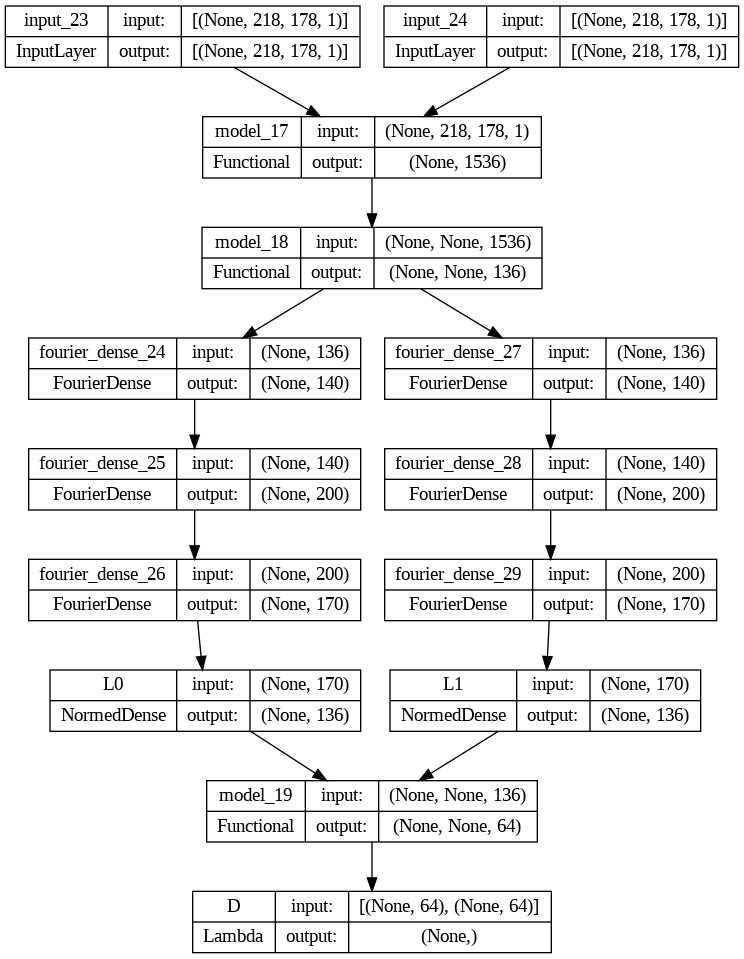

In [ ]:
mdl = body()
tf.keras.utils.plot_model(mdl, to_file='resqhub-ml-model.png', show_shapes=True)

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
141/141 [==============================] - 59s 382ms/step - loss: 1.3506 - L0_loss: 0.0214 - L1_loss: 0.0214 - D_loss: 0.1638 - val_loss: 1.1161 - val_L0_loss: 0.0477 - val_L1_loss: 0.0477 - val_D_loss: 0.1181
Epoch 2/20
141/141 [==============================] - 55s 386ms/step - loss: 1.0170 - L0_loss: 0.0216 - L1_loss: 0.0215 - D_loss: 0.1628 - val_loss: 0.9657 - val_L0_loss: 0.0477 - val_L1_loss: 0.0477 - val_D_loss: 0.1408
Epoch 3/20
141/141 [==============================] - 56s 388ms/step - loss: 0.8568 - L0_loss: 0.0215 - L1_loss: 0.0214 - D_loss: 0.1490 - val_loss: 0.8568 - val_L0_loss: 0.0477 - val_L1_loss: 0.0478 - val_D_loss: 0.1541
Epoch 4/20
141/141 [==============================] - 56s 389ms/step - loss: 0.7385 - L0_loss: 0.0217 - L1_loss: 0.0215 - D_loss: 0.1408 - val_loss: 0.7655 - val_L0_loss: 0.0482 - val_L1_loss: 0.0478 - val_D_loss: 0.1632
Epoch 5/20
141/141 [==============================] - 56s 389ms/step - loss: 0.6397 - L0_loss: 0.0219 - L1_loss: 0.0

In [ ]:
mdl.save('rai--fourier-L2-0.01---checkpoint-1.h5')
history = hist.history
with open('rai--fourier-L2-0.01---checkpoint-1.json', 'w') as f:
  json.dump(history, f)

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
141/141 [==============================] - 61s 393ms/step - loss: 0.3103 - L0_loss: 0.0247 - L1_loss: 0.0237 - D_loss: 0.0980 - val_loss: 0.4239 - val_L0_loss: 0.0525 - val_L1_loss: 0.0509 - val_D_loss: 0.1546
Epoch 2/20
141/141 [==============================] - 56s 389ms/step - loss: 0.3064 - L0_loss: 0.0247 - L1_loss: 0.0237 - D_loss: 0.0961 - val_loss: 0.4286 - val_L0_loss: 0.0526 - val_L1_loss: 0.0510 - val_D_loss: 0.1628
Epoch 3/20
141/141 [==============================] - 55s 387ms/step - loss: 0.3018 - L0_loss: 0.0247 - L1_loss: 0.0237 - D_loss: 0.0938 - val_loss: 0.4099 - val_L0_loss: 0.0525 - val_L1_loss: 0.0510 - val_D_loss: 0.1435
Epoch 4/20
141/141 [==============================] - 55s 386ms/step - loss: 0.3032 - L0_loss: 0.0247 - L1_loss: 0.0238 - D_loss: 0.0963 - val_loss: 0.4093 - val_L0_loss: 0.0528 - val_L1_loss: 0.0510 - val_D_loss: 0.1444
Epoch 5/20
141/141 [==============================] - 55s 387ms/step - loss: 0.3018 - L0_loss: 0.0247 - L1_loss: 0.0

In [ ]:
mdl.save('rai--fourier-L2-0.01---checkpoint-2.h5')
history = hist.history
with open('rai--fourier-L2-0.01---checkpoint-2.json', 'w') as f:
  json.dump(history, f)

In [ ]:
mdl = tf.keras.models.load_model('rai--fourier-L2-0.01---checkpoint-2.h5', compile=False)

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
141/141 [==============================] - 82s 426ms/step - loss: 0.1686 - L0_loss: 0.0229 - L1_loss: 0.0229 - D_loss: 0.1227 - val_loss: 0.2256 - val_L0_loss: 0.0488 - val_L1_loss: 0.0488 - val_D_loss: 0.1280
Epoch 2/20
141/141 [==============================] - 55s 382ms/step - loss: 0.1654 - L0_loss: 0.0226 - L1_loss: 0.0223 - D_loss: 0.1206 - val_loss: 0.2232 - val_L0_loss: 0.0487 - val_L1_loss: 0.0483 - val_D_loss: 0.1261
Epoch 3/20
141/141 [==============================] - 54s 378ms/step - loss: 0.1654 - L0_loss: 0.0222 - L1_loss: 0.0220 - D_loss: 0.1213 - val_loss: 0.2191 - val_L0_loss: 0.0481 - val_L1_loss: 0.0480 - val_D_loss: 0.1229
Epoch 4/20
141/141 [==============================] - 57s 397ms/step - loss: 0.1760 - L0_loss: 0.0222 - L1_loss: 0.0216 - D_loss: 0.1322 - val_loss: 0.2257 - val_L0_loss: 0.0490 - val_L1_loss: 0.0477 - val_D_loss: 0.1291
Epoch 5/20
141/141 [==============================] - 56s 392ms/step - loss: 0.1552 - L0_loss: 0.0224 - L1_loss: 0.0

In [ ]:
mdl.save('rai--fourier-L2-0.01---checkpoint-3.h5')
history = hist.history
with open('rai--fourier-L2-0.01---checkpoint-3.json', 'w') as f:
  json.dump(history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 1,
    validation_data = valDs
)

141/141 [==============================] - 60s 381ms/step - loss: 0.1338 - L0_loss: 0.0213 - L1_loss: 0.0214 - D_loss: 0.0910 - val_loss: 0.2125 - val_L0_loss: 0.0476 - val_L1_loss: 0.0474 - val_D_loss: 0.1175


In [ ]:
mdl.save('rai--fourier-L2-0.01---checkpoint-4.h5')
history = hist.history
with open('rai--fourier-L2-0.01---checkpoint-4.json', 'w') as f:
  json.dump(history, f)

# Attempt 1

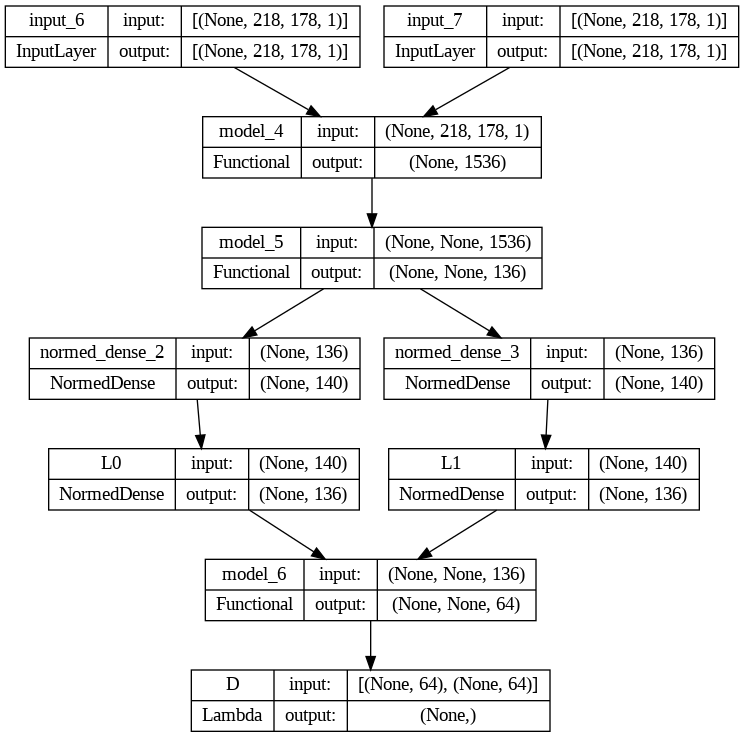

In [ ]:
mdl = body()
tf.keras.utils.plot_model(mdl, to_file='resqhub-ml-model.png', show_shapes=True)

In [ ]:
mdl.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-6)
)

hist = mdl.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
141/141 [==============================] - 56s 362ms/step - loss: 0.1952 - L0_loss: 0.0210 - L1_loss: 0.0210 - D_loss: 0.1532 - val_loss: 0.2069 - val_L0_loss: 0.0472 - val_L1_loss: 0.0473 - val_D_loss: 0.1124
Epoch 2/20
141/141 [==============================] - 52s 362ms/step - loss: 0.1926 - L0_loss: 0.0210 - L1_loss: 0.0210 - D_loss: 0.1507 - val_loss: 0.2030 - val_L0_loss: 0.0472 - val_L1_loss: 0.0472 - val_D_loss: 0.1087
Epoch 3/20
141/141 [==============================] - 53s 371ms/step - loss: 0.1900 - L0_loss: 0.0210 - L1_loss: 0.0210 - D_loss: 0.1480 - val_loss: 0.1974 - val_L0_loss: 0.0472 - val_L1_loss: 0.0472 - val_D_loss: 0.1029
Epoch 4/20
141/141 [==============================] - 52s 364ms/step - loss: 0.1887 - L0_loss: 0.0210 - L1_loss: 0.0210 - D_loss: 0.1466 - val_loss: 0.1936 - val_L0_loss: 0.0474 - val_L1_loss: 0.0472 - val_D_loss: 0.0990
Epoch 5/20
141/141 [==============================] - 52s 360ms/step - loss: 0.1848 - L0_loss: 0.0210 - L1_loss: 0.0

In [ ]:
mdl.save('rai-checkpoint-1.h5')
history = hist.history
with open('rai-checkpoint-1.json', 'w') as f:
  json.dump(history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


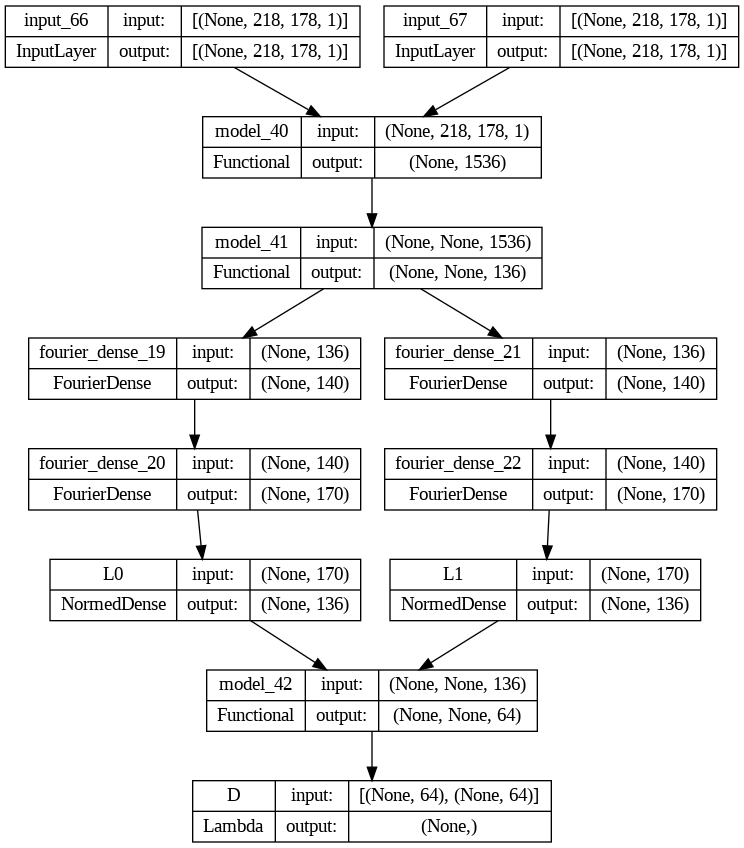

In [ ]:
mdlAlter = body()
tf.keras.utils.plot_model(mdlAlter, to_file='resqhub-ml-model.png', show_shapes=True)

In [ ]:
mdlAlter.compile(
  loss = [Loss0(), Loss1(), Loss2()],
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-6)
)

histAlter = mdlAlter.fit(
    x = trainDs,
    epochs = 20,
    validation_data = valDs
)

Epoch 1/20
141/141 [==============================] - 56s 354ms/step - loss: 0.1950 - L0_loss: 0.0213 - L1_loss: 0.0217 - D_loss: 0.1520 - val_loss: 0.2110 - val_L0_loss: 0.0477 - val_L1_loss: 0.0480 - val_D_loss: 0.1154
Epoch 2/20
141/141 [==============================] - 53s 364ms/step - loss: 0.1927 - L0_loss: 0.0213 - L1_loss: 0.0217 - D_loss: 0.1497 - val_loss: 0.2036 - val_L0_loss: 0.0476 - val_L1_loss: 0.0480 - val_D_loss: 0.1079
Epoch 3/20
141/141 [==============================] - 52s 363ms/step - loss: 0.1870 - L0_loss: 0.0213 - L1_loss: 0.0217 - D_loss: 0.1440 - val_loss: 0.1998 - val_L0_loss: 0.0477 - val_L1_loss: 0.0481 - val_D_loss: 0.1040
Epoch 4/20
141/141 [==============================] - 52s 365ms/step - loss: 0.1865 - L0_loss: 0.0213 - L1_loss: 0.0217 - D_loss: 0.1435 - val_loss: 0.1959 - val_L0_loss: 0.0475 - val_L1_loss: 0.0481 - val_D_loss: 0.1002
Epoch 5/20
141/141 [==============================] - 52s 365ms/step - loss: 0.1840 - L0_loss: 0.0213 - L1_loss: 0.0

In [ ]:
mdlAlter.save('rai-checkpoint-fourier-1.h5')
history = histAlter.history
with open('rai-checkpoint-fourier-1.json', 'w') as f:
  json.dump(history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
